# Geophysical particle filter

The point of this notebook is to recreate on an unclassified dataset and unrelated codebase the deep water bathymetric particle filter results, and include additional results for gravity and magnetic measurements. The function of this notebook is to serve as a prototyping and low-scale 'simulation' environment. 

First, let's import the stuff needed.

In [1]:
import numpy as np
from gmt_tool import get_map_section, inflate_bounds, get_map_point
from haversine import haversine, Unit
from tools import load_trackline_data
from matplotlib import pyplot as plt
from particle_filter import run_particle_filter, propagate
import pandas as pd
from datetime import timedelta
from scipy.io import savemat

First we need to tune the particle filter propagation noise to be similar to that of a marine-grade inertial navigation system. A low-end marine-grade INS should have a drift of 1 nm per 24 hours.

In [11]:
from particle_filter import rmse

time = 24*60 # minutes
noise = np.array([0, 0.1 * np.sqrt(1/60),0])
bound = 1852 # meters
v = 4*bound / 3600 # m / min
P = np.asarray([[0,0,0,0,v,0]])
T = P
err = rmse(P[0,:2], T[0, :2])
errors = [err]
t = 0
u = [0,v,0]

while t < time:    
    P = propagate(P, u, noise=noise)
    T = propagate(T, u, noise=[0,0,0])
    errors.append(rmse(P[0,:2], T[0, :2]))

plt.plot(errors)

IndexError: invalid index to scalar variable.

In [5]:
P = propagate(P, [0,v,0], 60)

In [10]:
P[0, :2]

array([0., 0.])

We'll first do some general examination of the data. Namely, investigating the sensor measurements to see if we can build a reasonable sensor model.

In [2]:
d_bathy = np.asarray([])
#d_grav = np.asarray([])
#d_mag = np.asarray([])
for i in range(20):
    data = load_trackline_data(f'./data/processed/marine_trackline_{i}.csv')
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    bathy_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'relief', '15s', f'track{i}')
#    grav_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'gravity', '01m', f'track{i}')
#    mag_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'magnetic', '02m', f'track{i}')
    d_bathy = np.hstack([d_bathy, data['CORR_DEPTH'] - (-get_map_point(bathy_map, data.LON, data.LAT))])
#    d_grav = np.hstack([data['FREEAIR'] - get_map_point(grav_map, data.LON, data.LAT)])
#    d_mag = np.hstack([data['CORR_DEPTH'] - get_map_point(bathy_map, data.LON, data.LAT)])

bathy_sigma = np.std(d_bathy, where=~np.isnan(d_bathy))

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-47.55615/-41.84205/45.7100875/46.7018425 -Gtrack0.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-47.55615/-41.84205/45.7100875/46.7018425 -Gtrack0.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -47.55615 to -47.5583333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -41.84205 to -41.8416666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.7100875 to 45.7083333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 46.7018425 to 46.7041666667\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-44.886642499999994/-42.3649475/45.6599725/47.1653575 -Gtrack1.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-44.886642499999994/-42.3649475/45.6599725/47.1653575 -Gtrack1.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -44.8866425 to -44.8875\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -42.3649475 to -42.3625\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.6599725 to 45.6583333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 47.1653575 to 47.1666666667\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-46.639872499999996/-44.031657499999994/46.684712499999996/48.0631975 -Gtrack2.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-46.639872499999996/-44.031657499999994/46.684712499999996/48.0631975 -Gtrack2.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -46.6398725 to -46.6416666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -44.0316575 to -44.0291666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 46.6847125 to 46.6833333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 48.0631975 to 48.0666666667\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-45.871894999999995/-41.94912499999998/45.4632/47.73102 -Gtrack3.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-45.871894999999995/-41.94912499999998/45.4632/47.73102 -Gtrack3.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -45.871895 to -45.875\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -41.949125 to -41.9458333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.4632 to 45.4625\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 47.73102 to 47.7333333333\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-47.912665000000004/-42.462954999999994/44.127587500000004/46.9596625 -Gtrack4.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-47.912665000000004/-42.462954999999994/44.127587500000004/46.9596625 -Gtrack4.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -47.912665 to -47.9166666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -42.462955 to -42.4625\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.1275875 to 44.125\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 46.9596625 to 46.9625\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-48.01899500000002/-42.316325000000006/44.1881125/46.983617499999994 -Gtrack5.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-48.01899500000002/-42.316325000000006/44.1881125/46.983617499999994 -Gtrack5.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -48.018995 to -48.0208333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -42.316325 to -42.3125\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.1881125 to 44.1875\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 46.9836175 to 46.9875\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-44.846577499999995/-44.31811250000001/44.969342499999996/45.6062875 -Gtrack6.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-44.846577499999995/-44.31811250000001/44.969342499999996/45.6062875 -Gtrack6.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -44.8465775 to -44.85\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -44.3181125 to -44.3166666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.9693425 to 44.9666666667\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 45.6062875 to 45.6083333333\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-45.62542500000001/-45.272355000000005/45.5263425/45.904267499999996 -Gtrack7.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-45.62542500000001/-45.272355000000005/45.5263425/45.904267499999996 -Gtrack7.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -45.625425 to -45.6291666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -45.272355 to -45.2708333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.5263425 to 45.525\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 45.9042675 to 45.9083333333\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-47.44549000000001/-44.145849999999996/43.1226525/46.026577499999995 -Gtrack8.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-47.44549000000001/-44.145849999999996/43.1226525/46.026577499999995 -Gtrack8.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -47.44549 to -47.4458333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -44.14585 to -44.1458333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 43.1226525 to 43.1208333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 46.0265775 to 46.0291666667\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-51.77676250000002/-45.8711275/44.2257525/47.5353975 -Gtrack9.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-51.77676250000002/-45.8711275/44.2257525/47.5353975 -Gtrack9.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -51.7767625 to -51.7791666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -45.8711275 to -45.8708333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.2257525 to 44.225\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 47.5353975 to 47.5375\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-51.77676250000002/-45.8711275/44.2257525/47.5353975 -Gtrack10.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-51.77676250000002/-45.8711275/44.2257525/47.5353975 -Gtrack10.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -51.7767625 to -51.7791666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -45.8711275 to -45.8708333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.2257525 to 44.225\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 47.5353975 to 47.5375\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-47.65320249999999/-40.576547500000004/29.86538/31.139 -Gtrack11.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-47.65320249999999/-40.576547500000004/29.86538/31.139 -Gtrack11.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -47.6532025 to -47.6541666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -40.5765475 to -40.575\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 29.86538 to 29.8625\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 31.139 to 31.1416666667\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-42.35966250000001/-41.7485475/29.9579125/30.3936175 -Gtrack12.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-42.35966250000001/-41.7485475/29.9579125/30.3936175 -Gtrack12.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -42.3596625 to -42.3625\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -41.7485475 to -41.7458333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 29.9579125 to 29.9541666667\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 30.3936175 to 30.3958333333\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd68.49788749999999/85.48816250000004/-22.393069999999998/-13.273489999999999 -Gtrack13.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd68.49788749999999/85.48816250000004/-22.393069999999998/-13.273489999999999 -Gtrack13.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 68.4978875 to 68.4958333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 85.4881625 to 85.4916666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -22.39307 to -22.3958333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -13.27349 to -13.2708333333\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd98.14033/112.23247000000003/-49.5169525/-35.7126775 -Gtrack14.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd98.14033/112.23247000000003/-49.5169525/-35.7126775 -Gtrack14.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 98.14033 to 98.1375\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 112.23247 to 112.233333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -49.5169525 to -49.5208333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -35.7126775 to -35.7125\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd99.66274499999997/102.98215500000003/-48.40363/-46.81135 -Gtrack15.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd99.66274499999997/102.98215500000003/-48.40363/-46.81135 -Gtrack15.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 99.662745 to 99.6625\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 102.982155 to 102.983333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -48.40363 to -48.4041666667\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -46.81135 to -46.8083333333\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd101.39120249999996/112.4880675/-50.582915/-47.316485 -Gtrack16.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd101.39120249999996/112.4880675/-50.582915/-47.316485 -Gtrack16.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 101.3912025 to 101.3875\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 112.4880675 to 112.491666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -50.582915 to -50.5833333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -47.316485 to -47.3125\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd109.41493000000003/110.82577000000003/-50.1463075/-49.2073225 -Gtrack17.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd109.41493000000003/110.82577000000003/-50.1463075/-49.2073225 -Gtrack17.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 109.41493 to 109.4125\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 110.82577 to 110.829166667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -50.1463075 to -50.15\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -49.2073225 to -49.2041666667\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd114.58496250000002/118.88844749999998/-50.38516750000001/-48.57360249999999 -Gtrack18.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd114.58496250000002/118.88844749999998/-50.38516750000001/-48.57360249999999 -Gtrack18.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 114.5849625 to 114.583333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 118.8884475 to 118.891666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -50.3851675 to -50.3875\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -48.5736025 to -48.5708333333\n\n')


c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd119.86845249999999/140.9111575/-50.068255/-46.093165 -Gtrack19.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd119.86845249999999/140.9111575/-50.068255/-46.093165 -Gtrack19.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 119.8684525 to 119.866666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 140.9111575 to 140.9125\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -50.068255 to -50.0708333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -46.093165 to -46.0916666667\n\n')


Now let's run the trajectory

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-47.55615/-41.84205/45.7100875/46.7018425 -Gtrack0.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-47.55615/-41.84205/45.7100875/46.7018425 -Gtrack0.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -47.55615 to -47.5583333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -41.84205 to -41.8416666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.7100875 to 45.7083333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 46.7018425 to 46.7041666667\n\n')


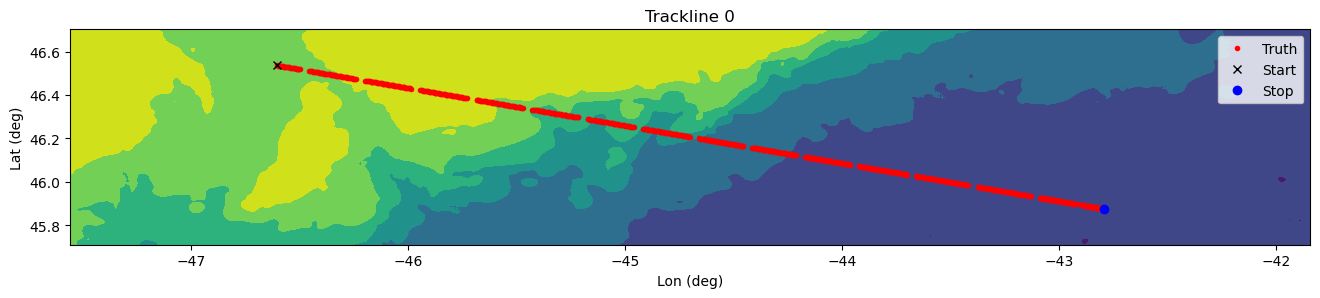

<Figure size 640x480 with 0 Axes>

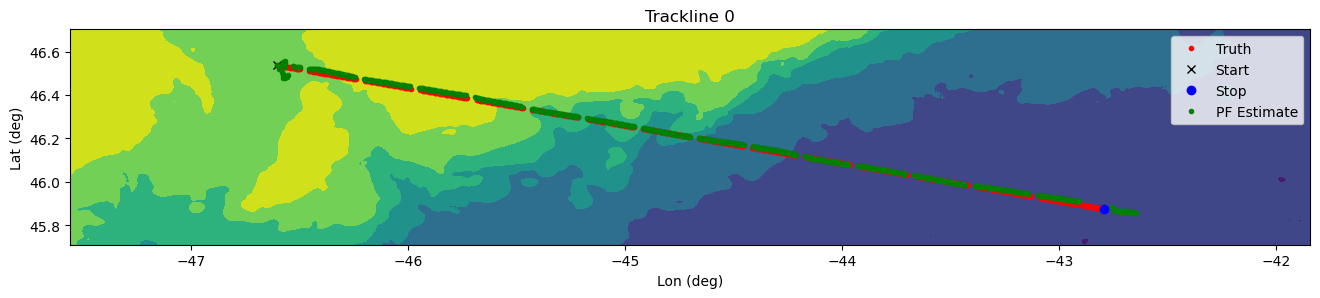

<Figure size 640x480 with 0 Axes>

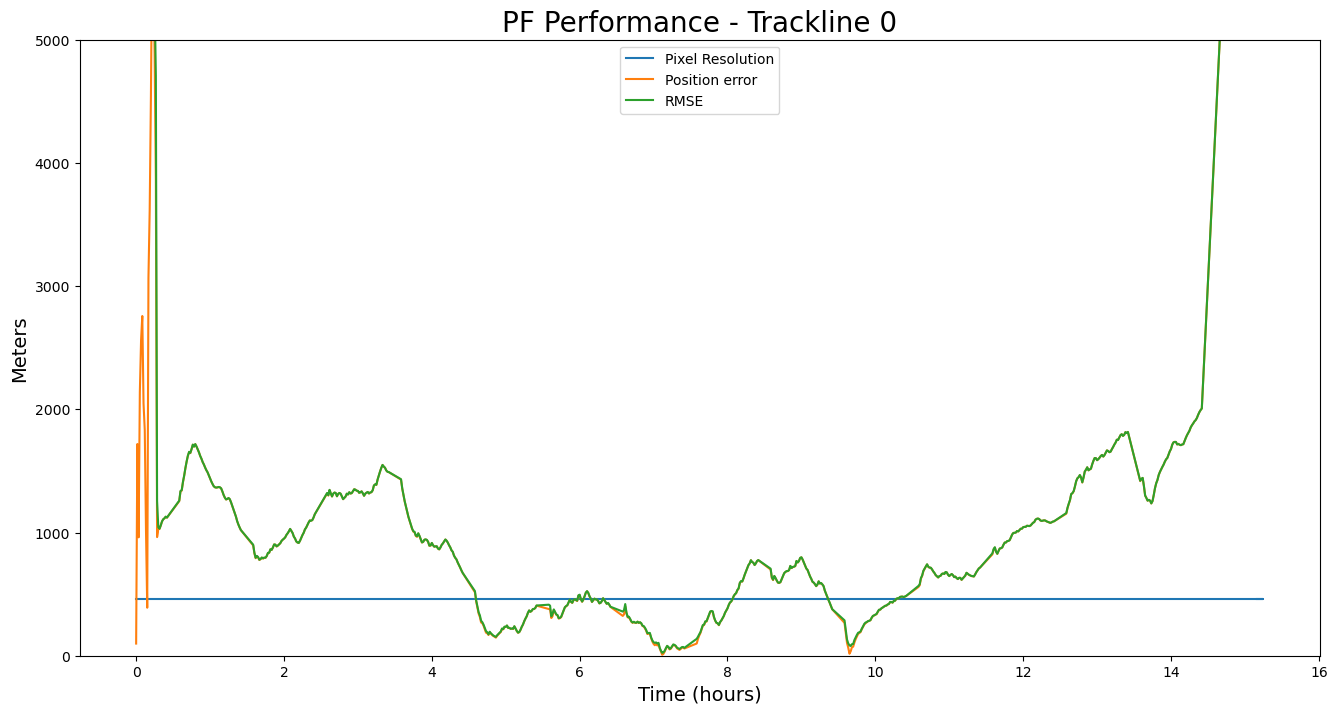

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-44.886642499999994/-42.3649475/45.6599725/47.1653575 -Gtrack1.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-44.886642499999994/-42.3649475/45.6599725/47.1653575 -Gtrack1.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -44.8866425 to -44.8875\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -42.3649475 to -42.3625\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.6599725 to 45.6583333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 47.1653575 to 47.1666666667\n\n')


<Figure size 640x480 with 0 Axes>

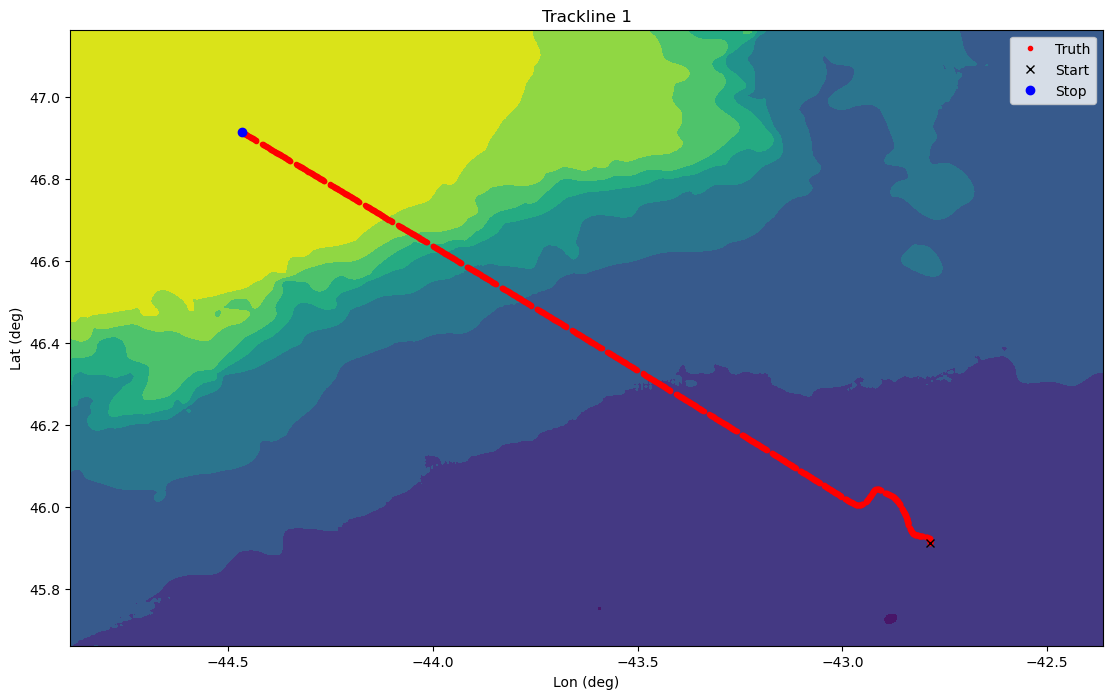

<Figure size 640x480 with 0 Axes>

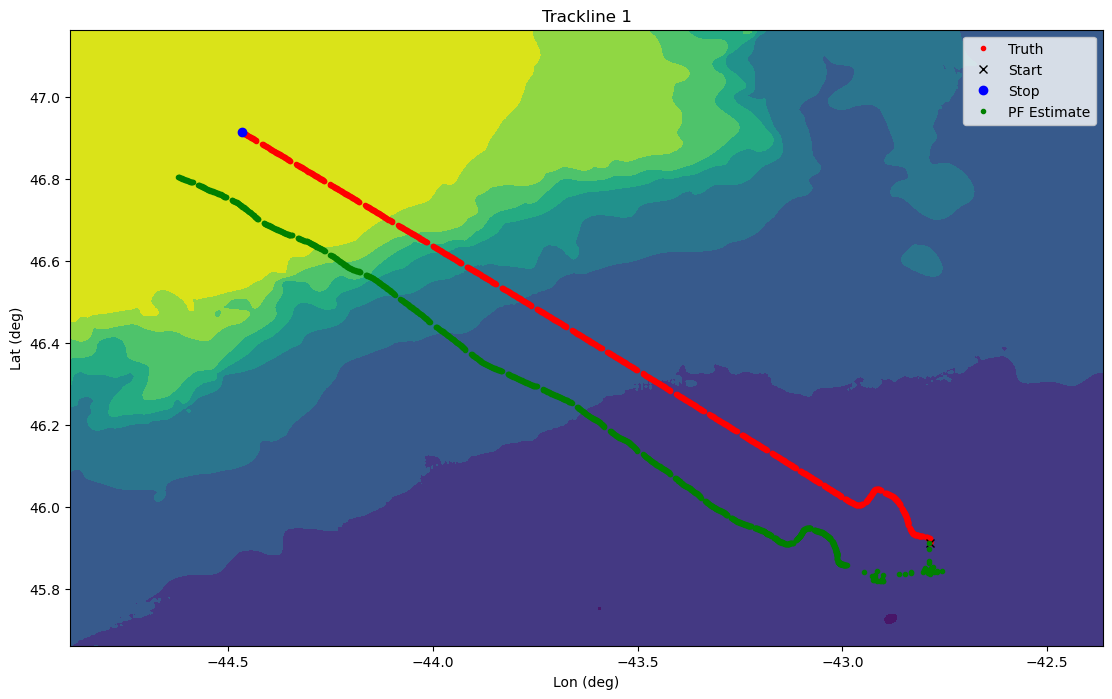

<Figure size 640x480 with 0 Axes>

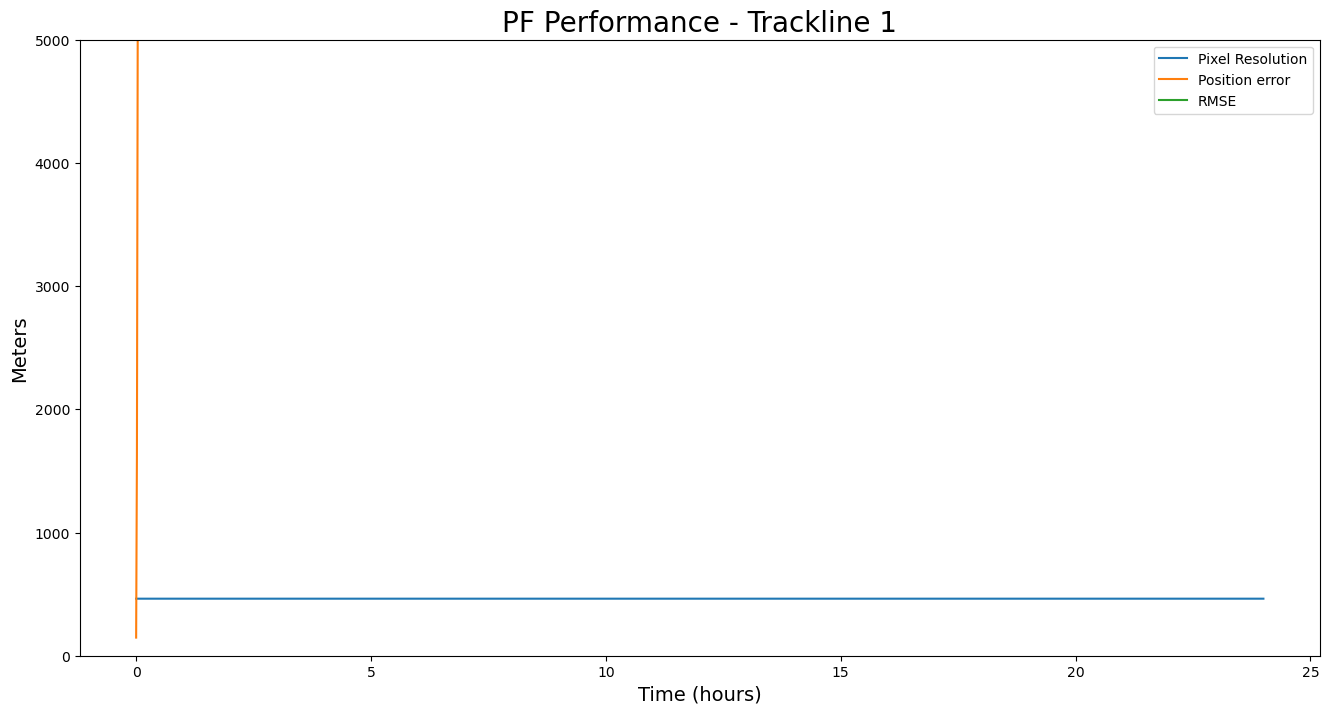

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-46.639872499999996/-44.031657499999994/46.684712499999996/48.0631975 -Gtrack2.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-46.639872499999996/-44.031657499999994/46.684712499999996/48.0631975 -Gtrack2.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -46.6398725 to -46.6416666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -44.0316575 to -44.0291666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 46.6847125 to 46.6833333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 48.0631975 to 48.0666666667\n\n')


<Figure size 640x480 with 0 Axes>

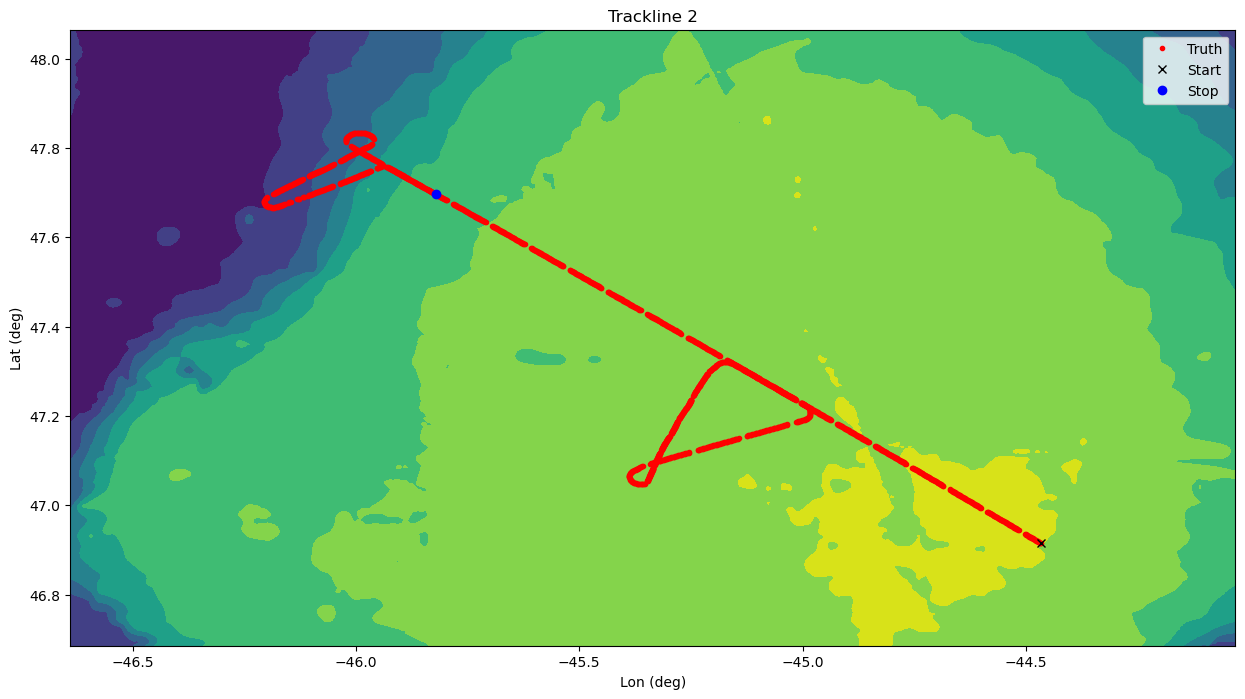

<Figure size 640x480 with 0 Axes>

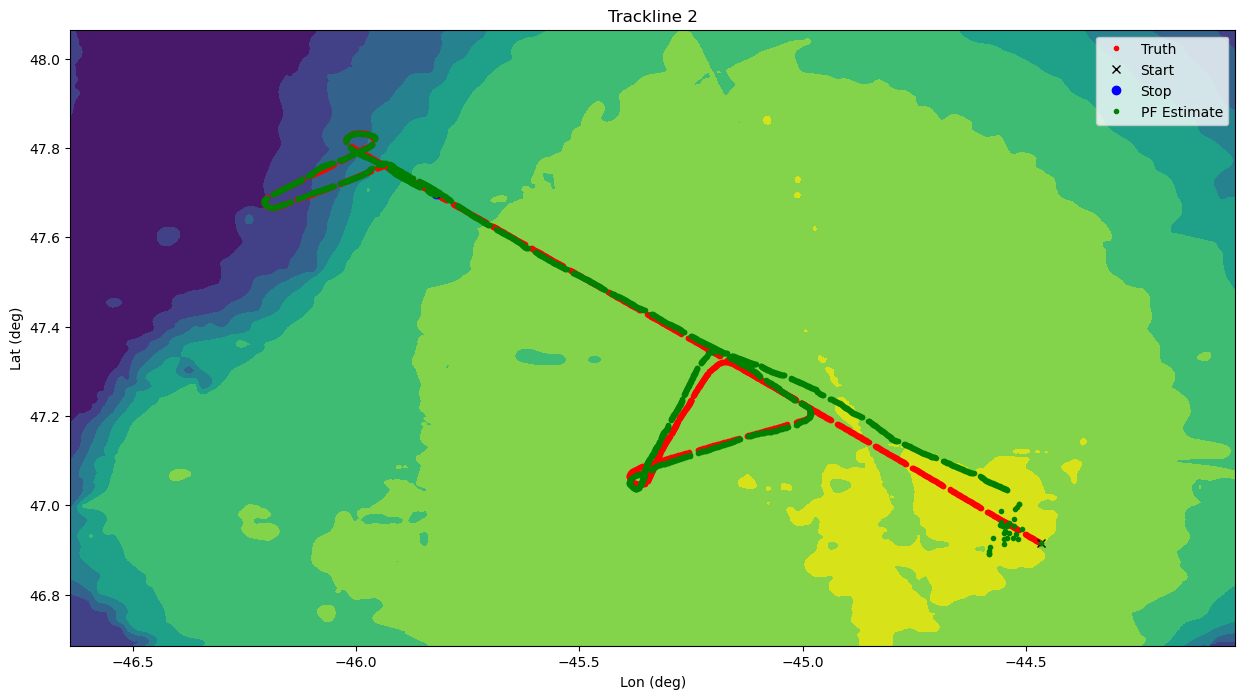

<Figure size 640x480 with 0 Axes>

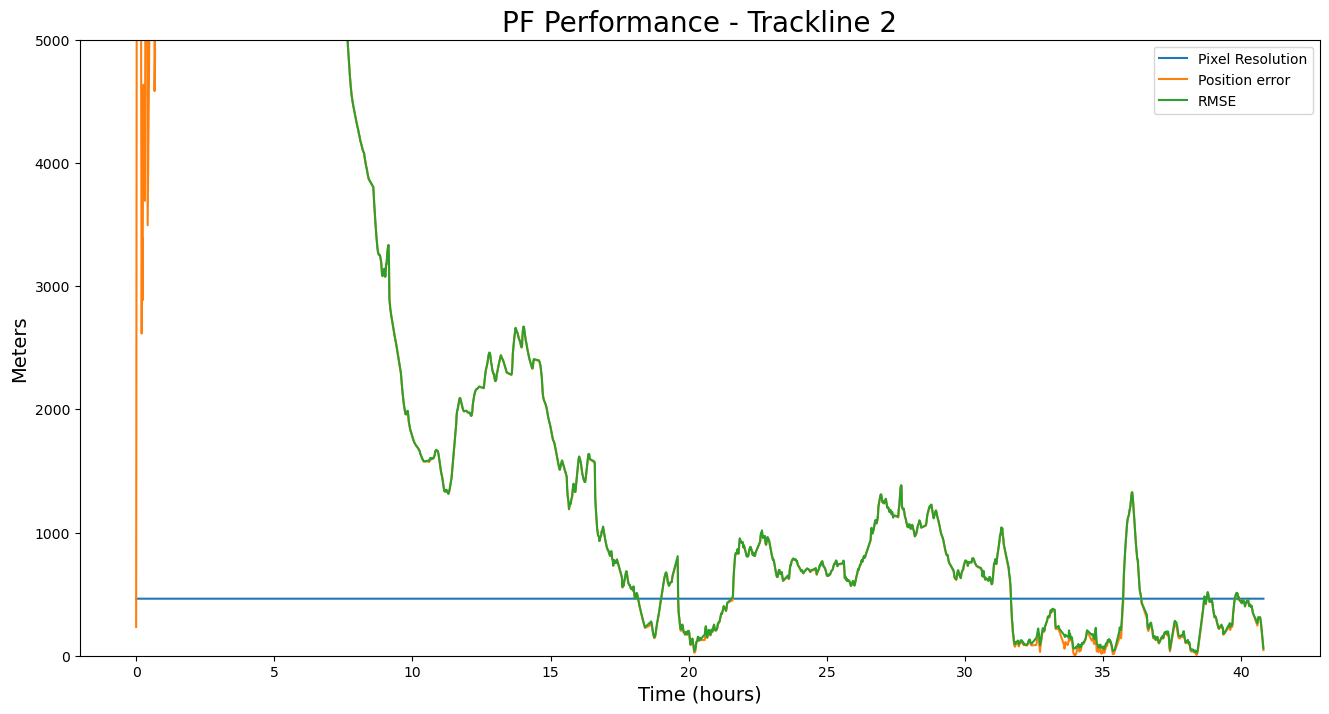

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-45.871894999999995/-41.94912499999998/45.4632/47.73102 -Gtrack3.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-45.871894999999995/-41.94912499999998/45.4632/47.73102 -Gtrack3.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -45.871895 to -45.875\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -41.949125 to -41.9458333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.4632 to 45.4625\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 47.73102 to 47.7333333333\n\n')


<Figure size 640x480 with 0 Axes>

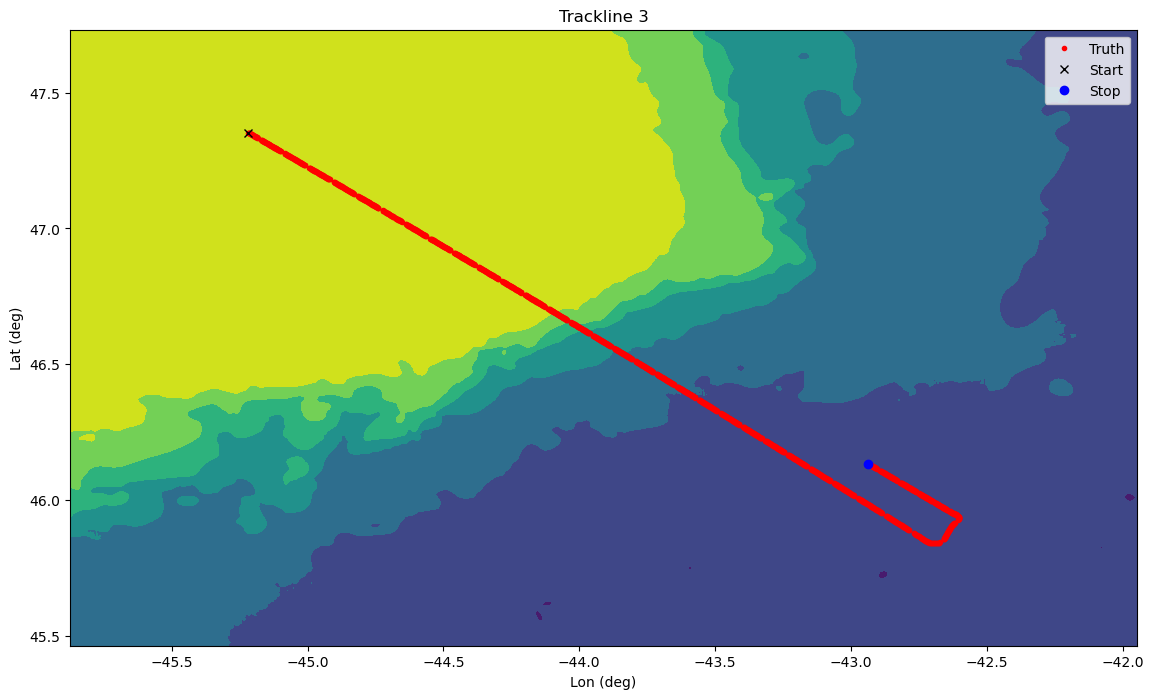

<Figure size 640x480 with 0 Axes>

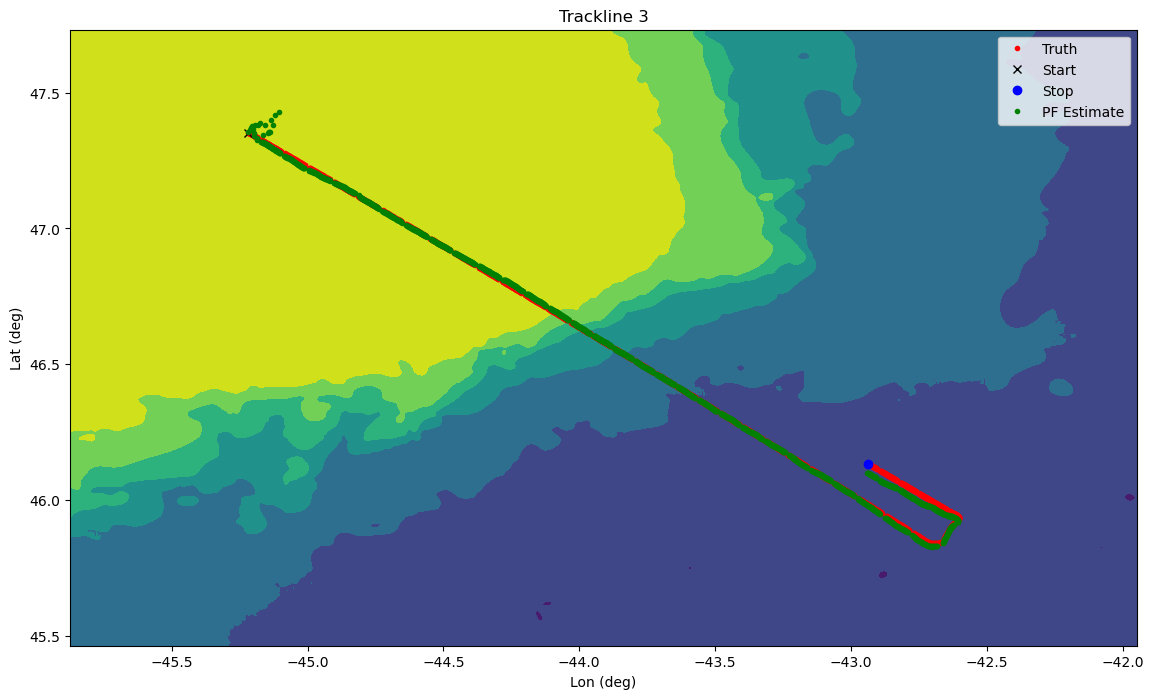

<Figure size 640x480 with 0 Axes>

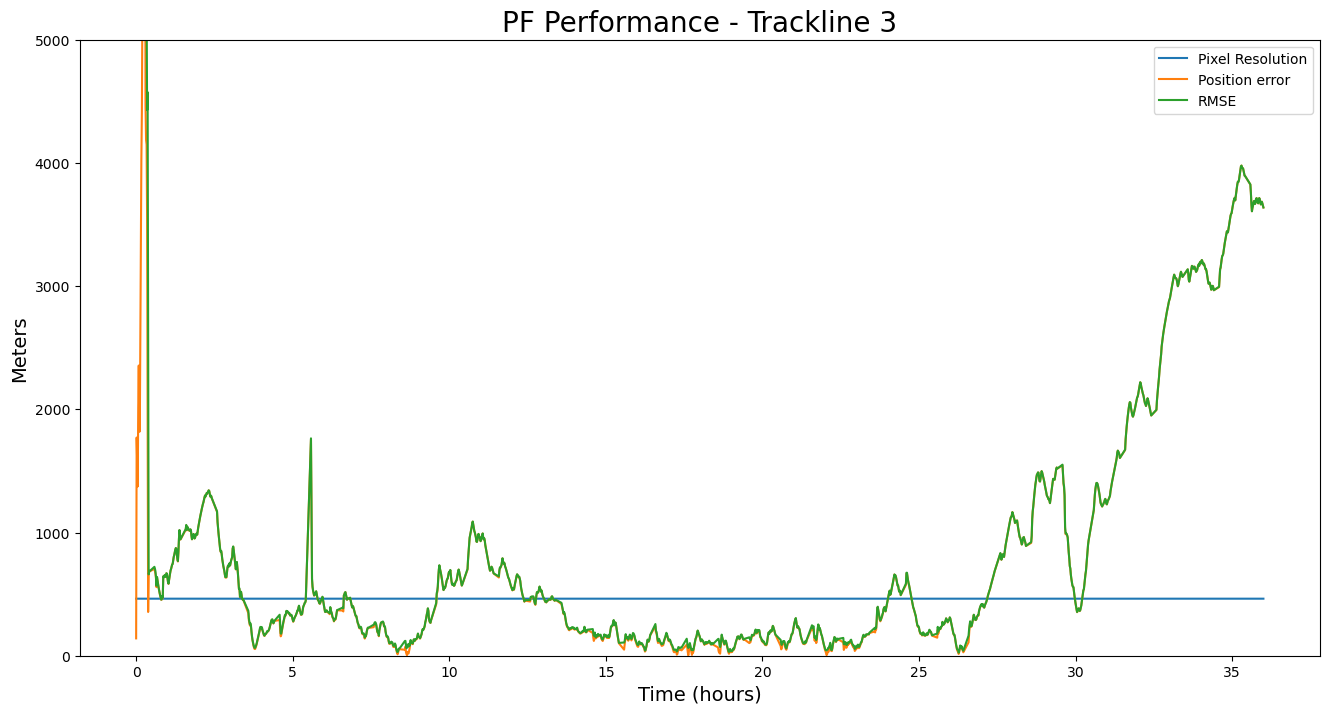

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-47.912665000000004/-42.462954999999994/44.127587500000004/46.9596625 -Gtrack4.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-47.912665000000004/-42.462954999999994/44.127587500000004/46.9596625 -Gtrack4.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -47.912665 to -47.9166666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -42.462955 to -42.4625\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.1275875 to 44.125\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 46.9596625 to 46.9625\n\n')


<Figure size 640x480 with 0 Axes>

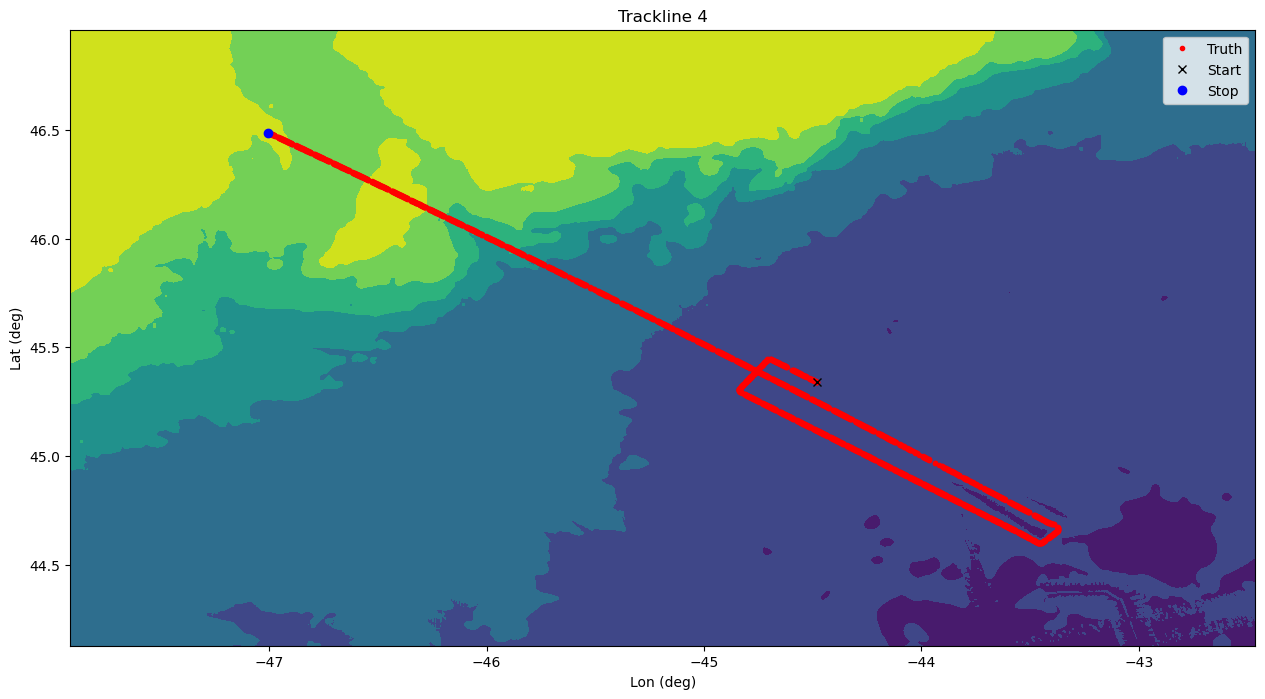

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

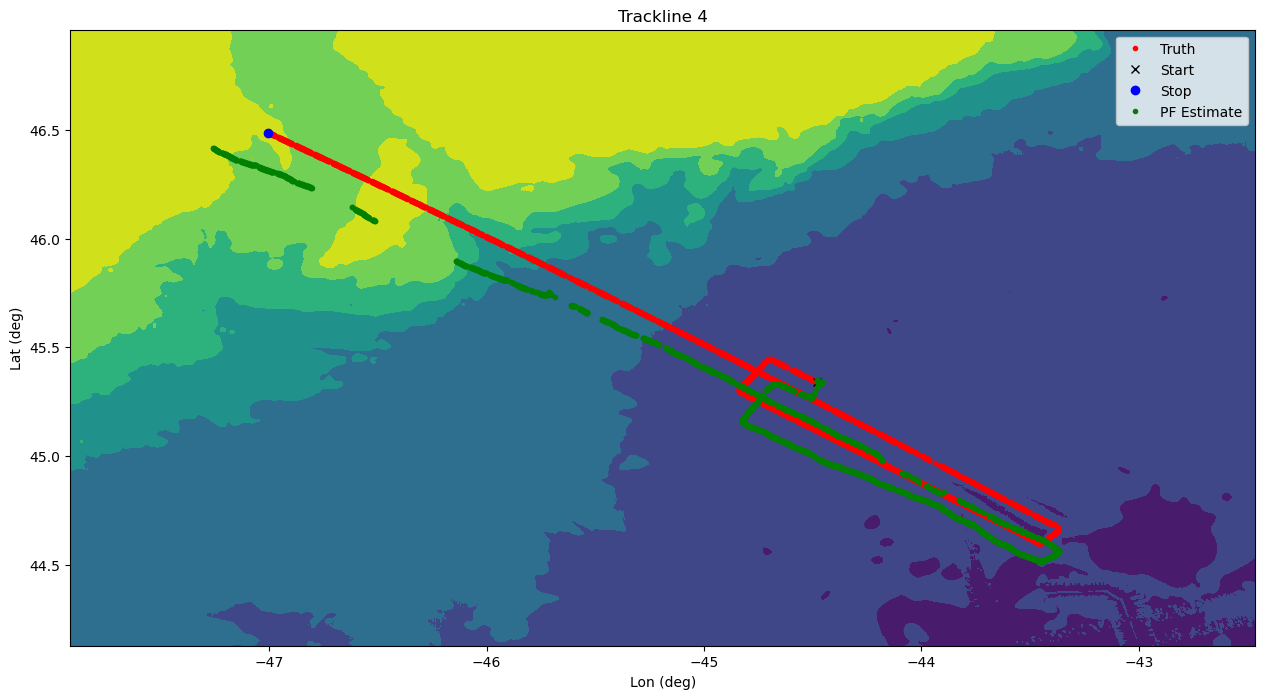

<Figure size 640x480 with 0 Axes>

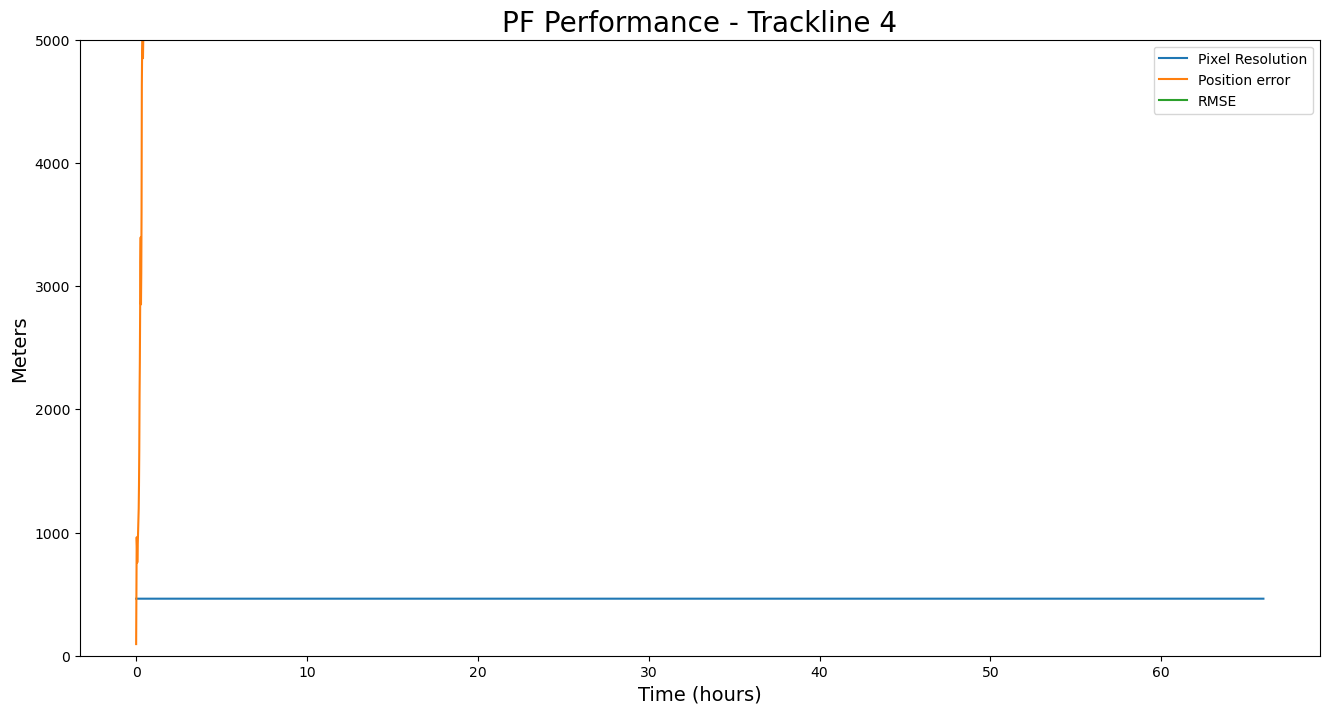

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-48.01899500000002/-42.316325000000006/44.1881125/46.983617499999994 -Gtrack5.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-48.01899500000002/-42.316325000000006/44.1881125/46.983617499999994 -Gtrack5.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -48.018995 to -48.0208333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -42.316325 to -42.3125\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.1881125 to 44.1875\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 46.9836175 to 46.9875\n\n')


<Figure size 640x480 with 0 Axes>

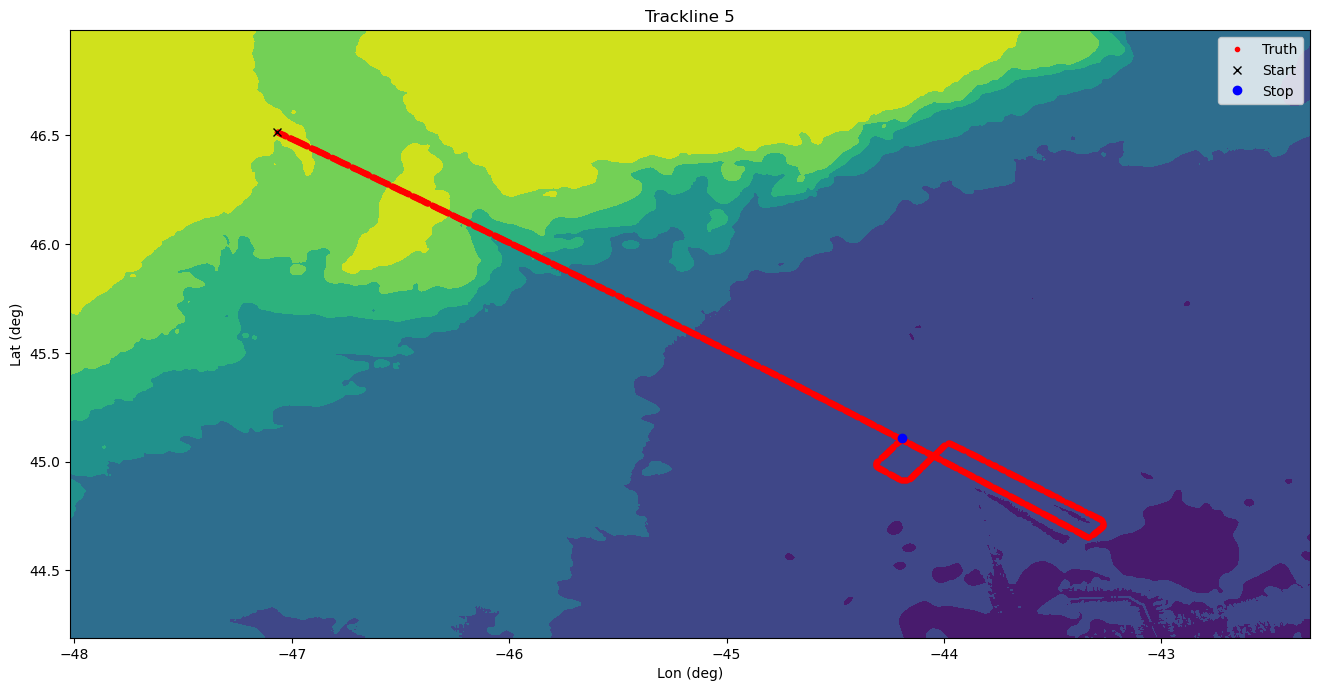

<Figure size 640x480 with 0 Axes>

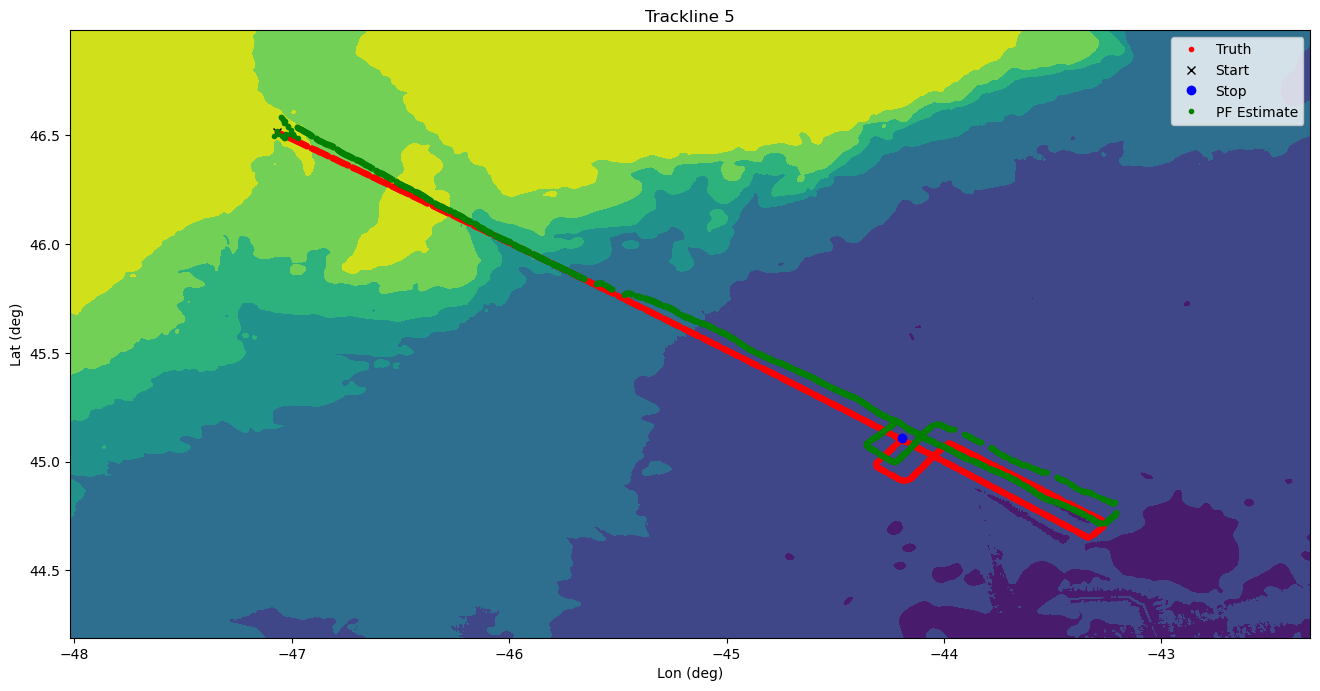

<Figure size 640x480 with 0 Axes>

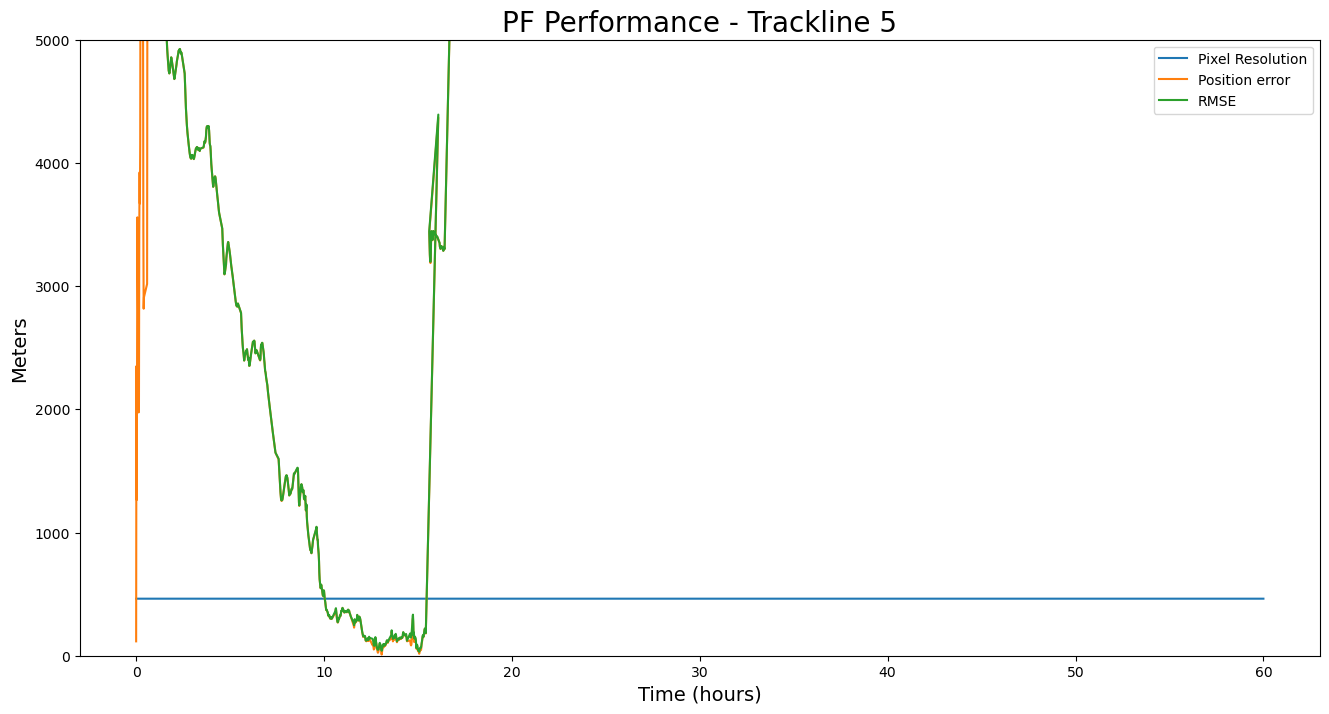

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-44.846577499999995/-44.31811250000001/44.969342499999996/45.6062875 -Gtrack6.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-44.846577499999995/-44.31811250000001/44.969342499999996/45.6062875 -Gtrack6.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -44.8465775 to -44.85\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -44.3181125 to -44.3166666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.9693425 to 44.9666666667\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 45.6062875 to 45.6083333333\n\n')


<Figure size 640x480 with 0 Axes>

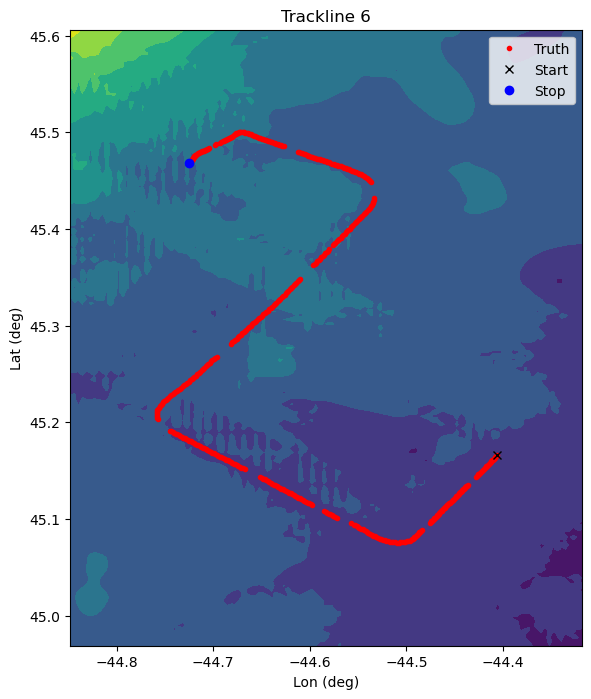

<Figure size 640x480 with 0 Axes>

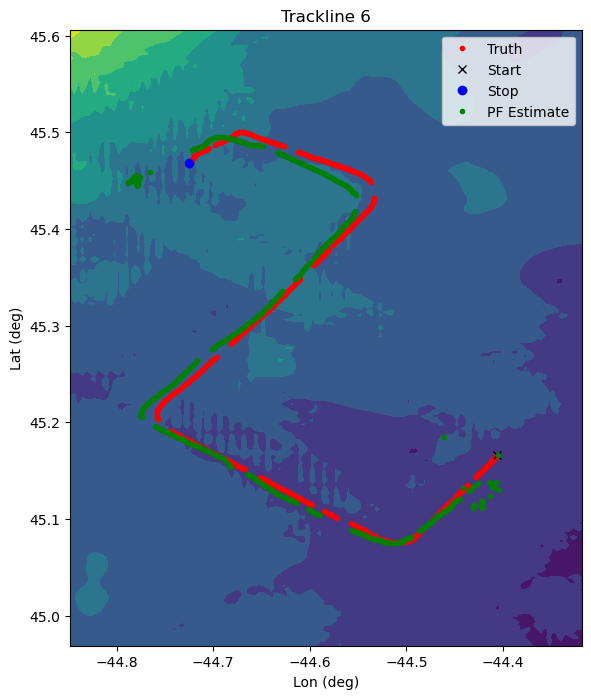

<Figure size 640x480 with 0 Axes>

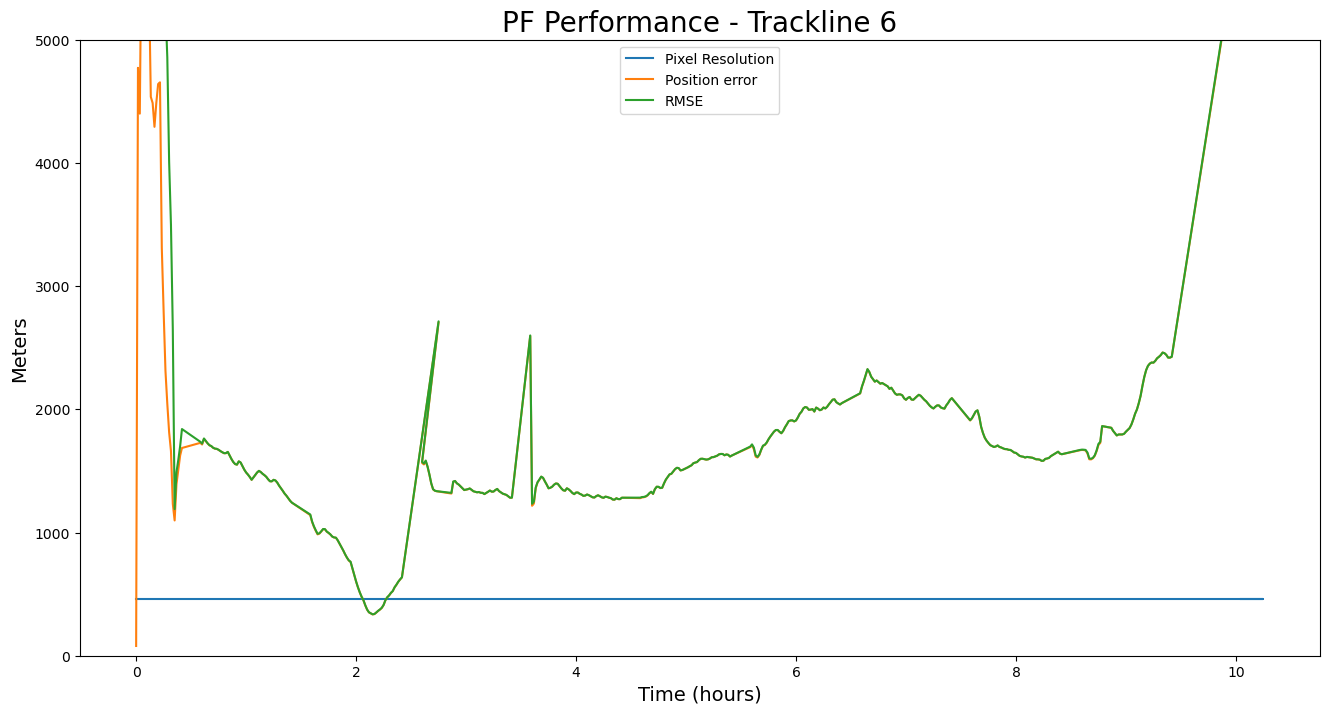

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-45.62542500000001/-45.272355000000005/45.5263425/45.904267499999996 -Gtrack7.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-45.62542500000001/-45.272355000000005/45.5263425/45.904267499999996 -Gtrack7.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -45.625425 to -45.6291666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -45.272355 to -45.2708333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.5263425 to 45.525\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 45.9042675 to 45.9083333333\n\n')


<Figure size 640x480 with 0 Axes>

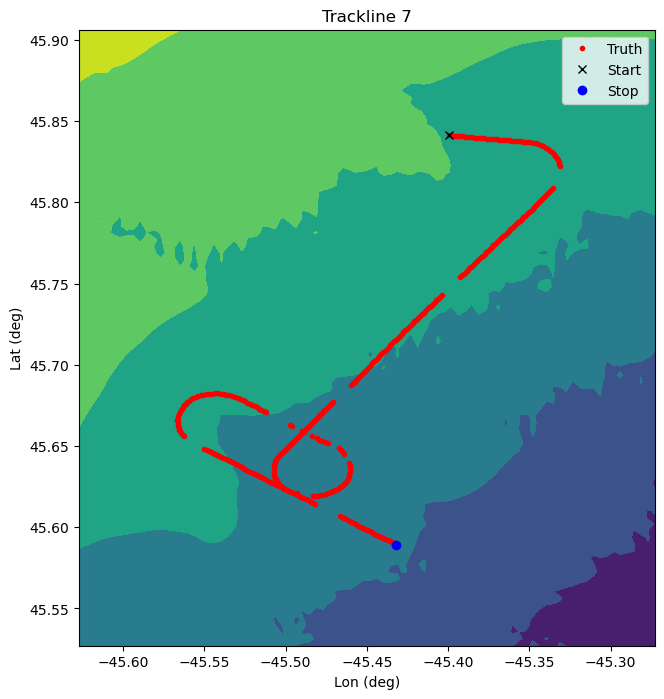

<Figure size 640x480 with 0 Axes>

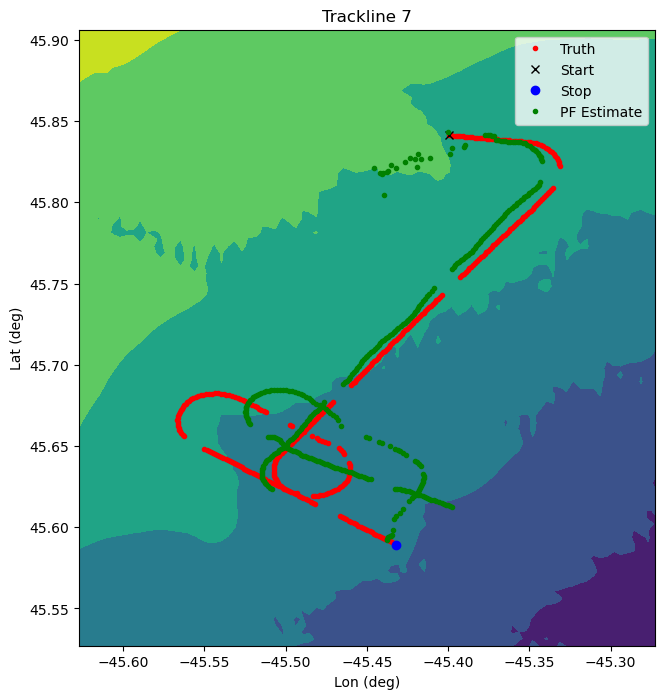

<Figure size 640x480 with 0 Axes>

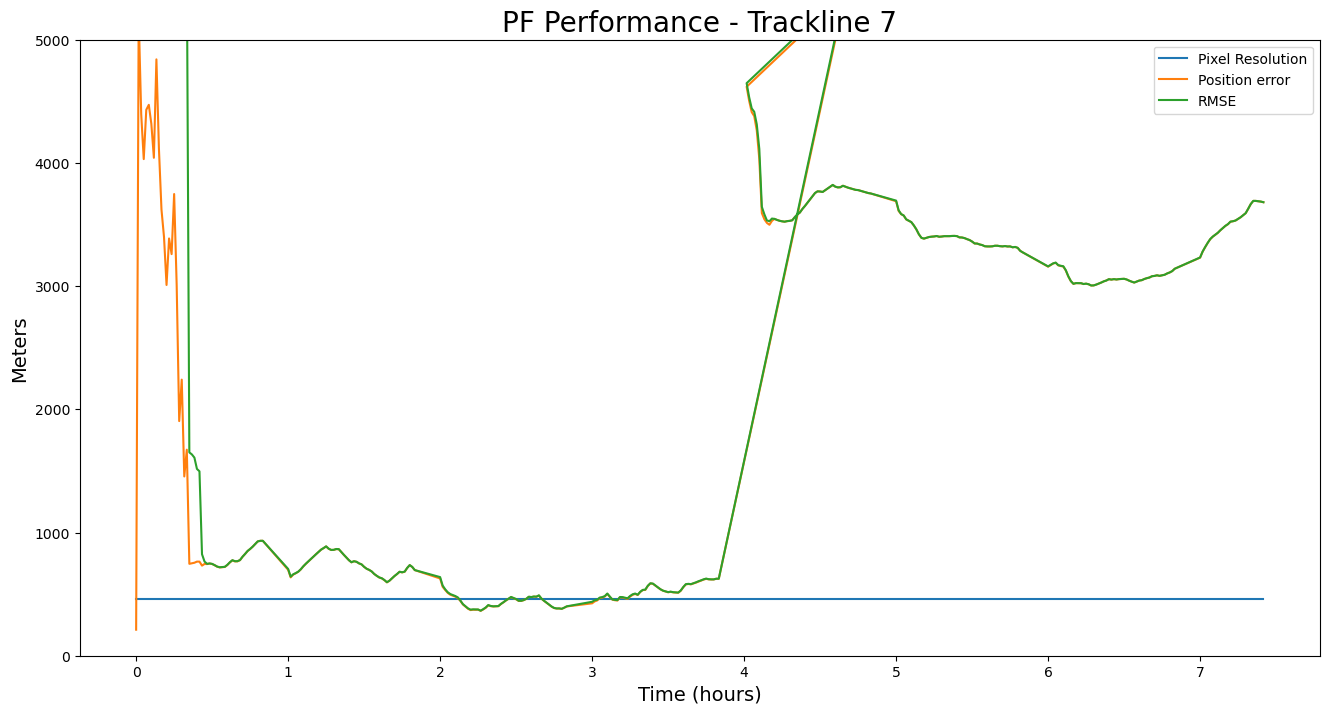

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-47.44549000000001/-44.145849999999996/43.1226525/46.026577499999995 -Gtrack8.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-47.44549000000001/-44.145849999999996/43.1226525/46.026577499999995 -Gtrack8.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -47.44549 to -47.4458333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -44.14585 to -44.1458333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 43.1226525 to 43.1208333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 46.0265775 to 46.0291666667\n\n')


<Figure size 640x480 with 0 Axes>

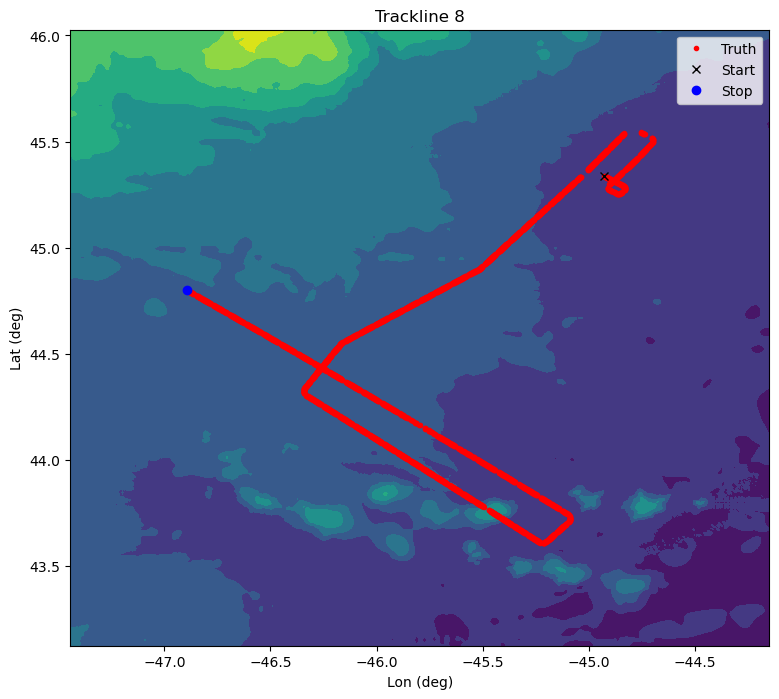

<Figure size 640x480 with 0 Axes>

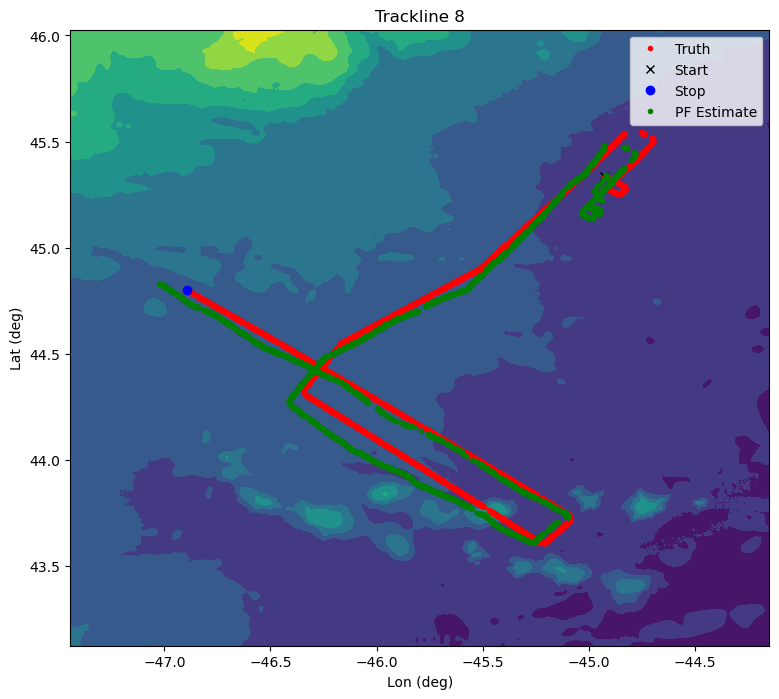

<Figure size 640x480 with 0 Axes>

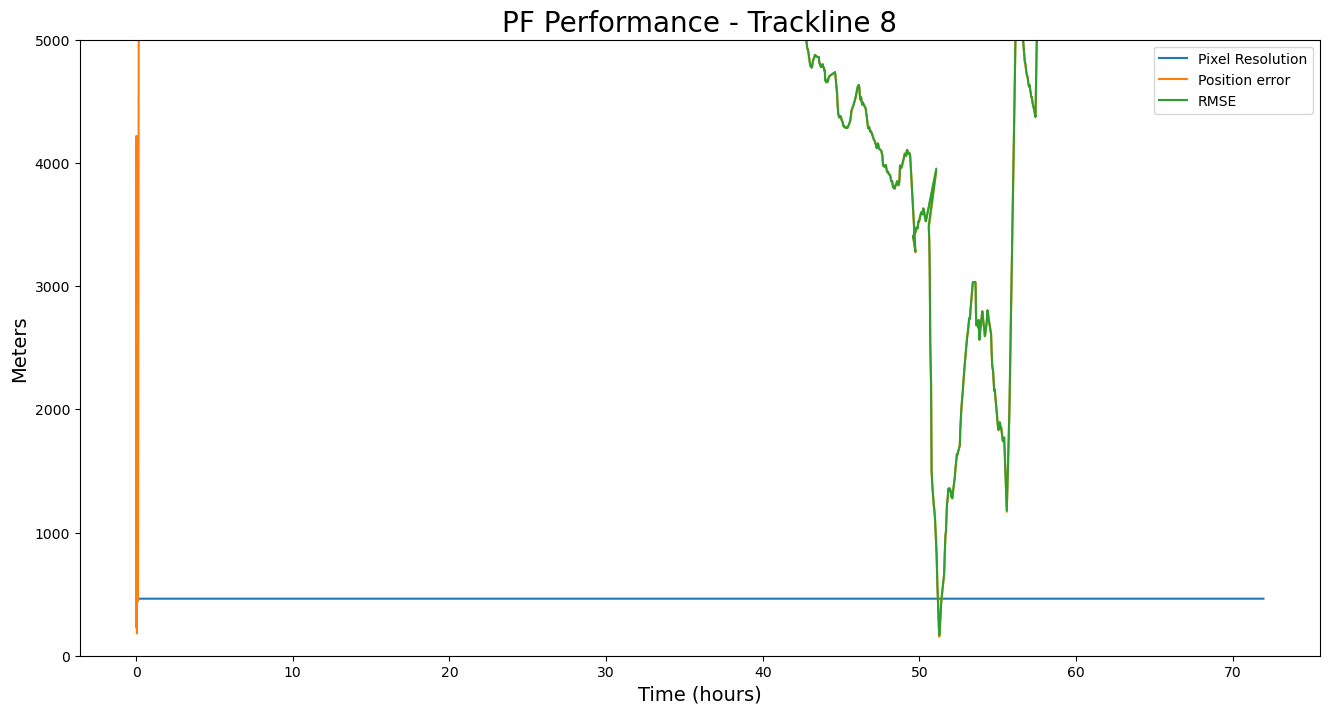

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-51.77676250000002/-45.8711275/44.2257525/47.5353975 -Gtrack9.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-51.77676250000002/-45.8711275/44.2257525/47.5353975 -Gtrack9.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -51.7767625 to -51.7791666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -45.8711275 to -45.8708333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.2257525 to 44.225\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 47.5353975 to 47.5375\n\n')


<Figure size 640x480 with 0 Axes>

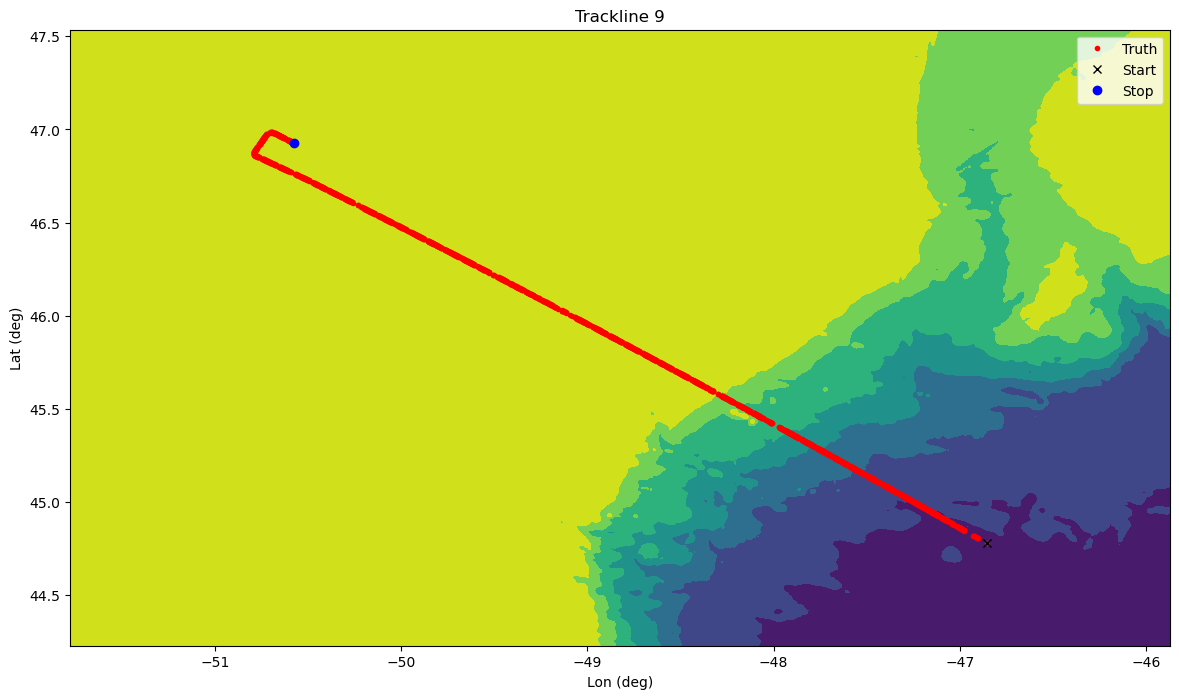

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

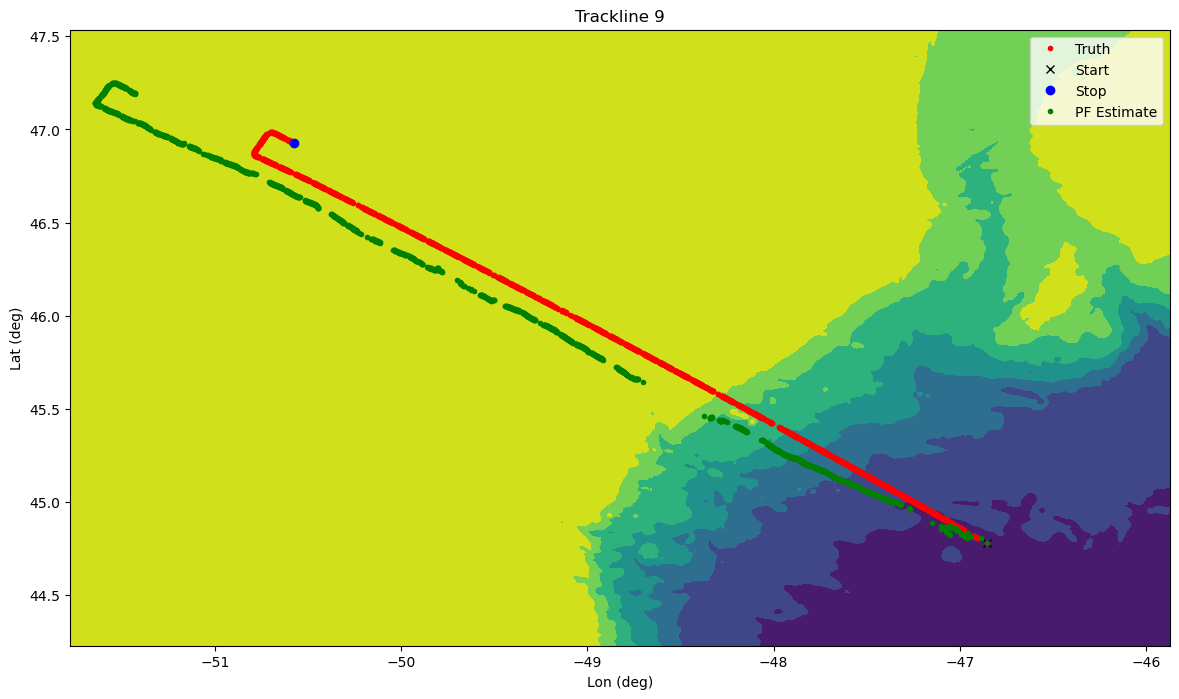

<Figure size 640x480 with 0 Axes>

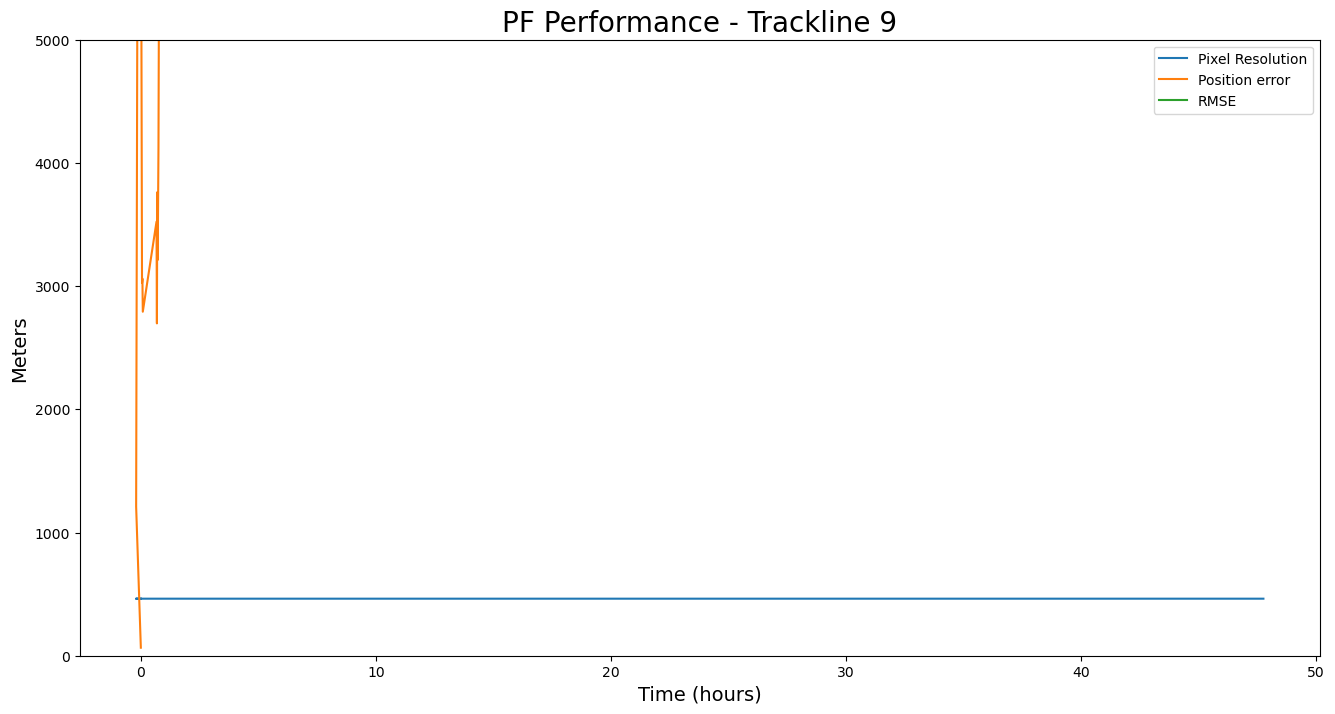

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-51.77676250000002/-45.8711275/44.2257525/47.5353975 -Gtrack10.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-51.77676250000002/-45.8711275/44.2257525/47.5353975 -Gtrack10.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -51.7767625 to -51.7791666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -45.8711275 to -45.8708333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 44.2257525 to 44.225\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 47.5353975 to 47.5375\n\n')


<Figure size 640x480 with 0 Axes>

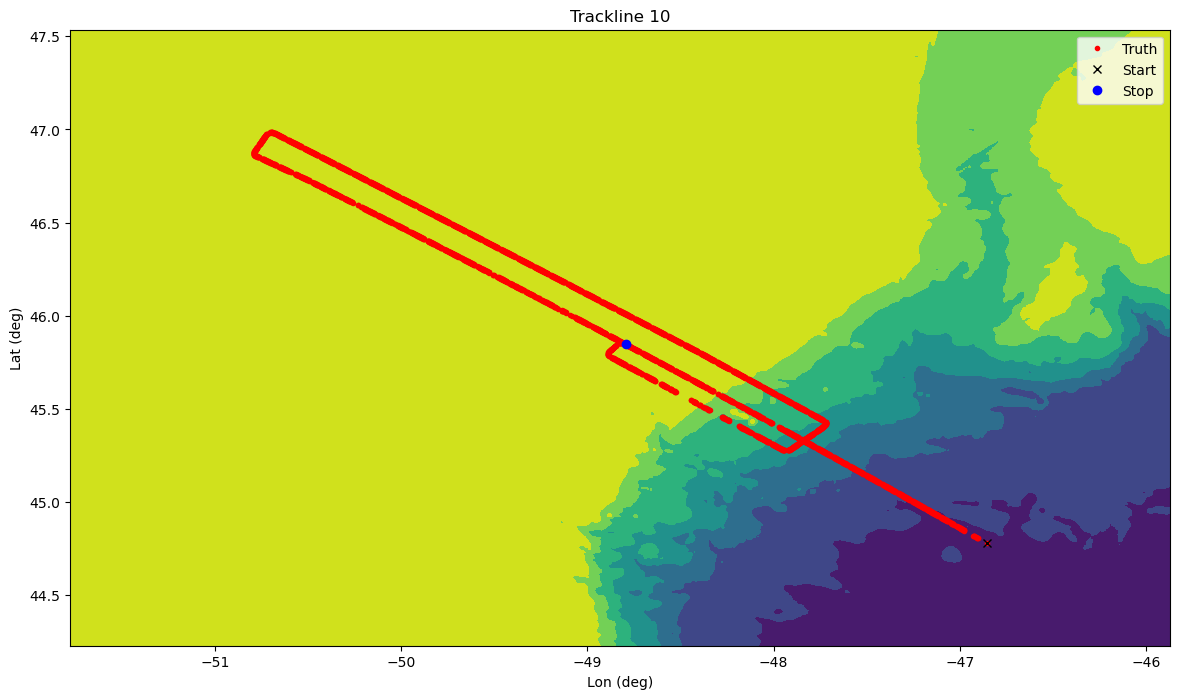

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

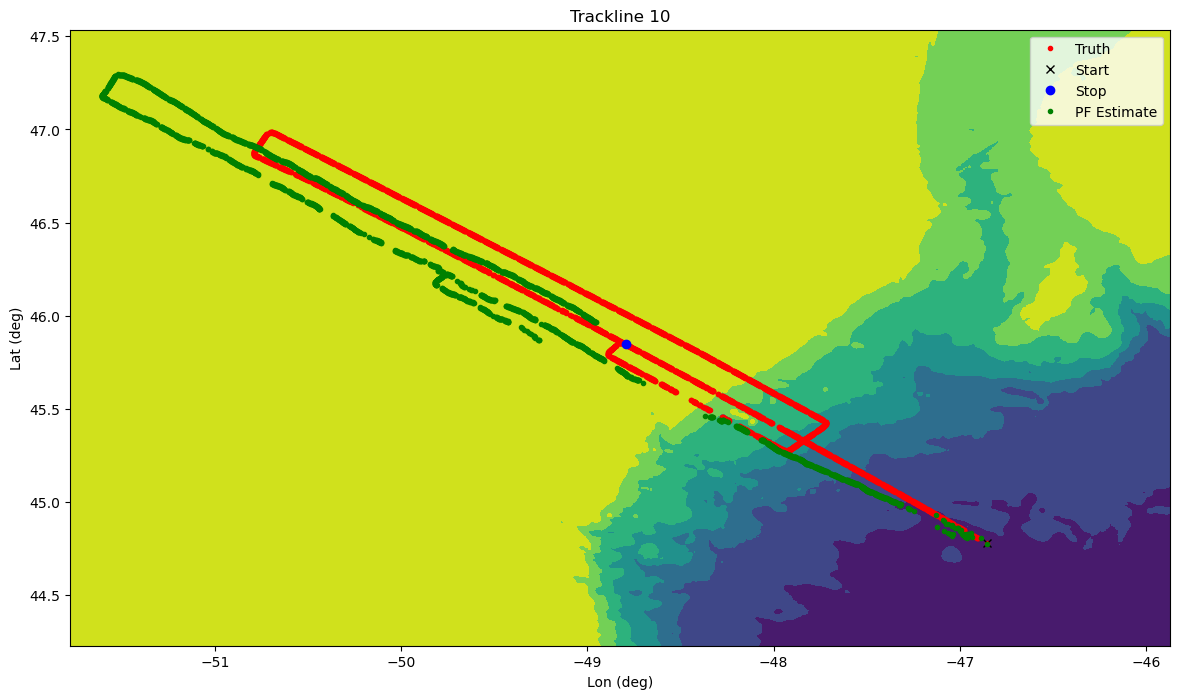

<Figure size 640x480 with 0 Axes>

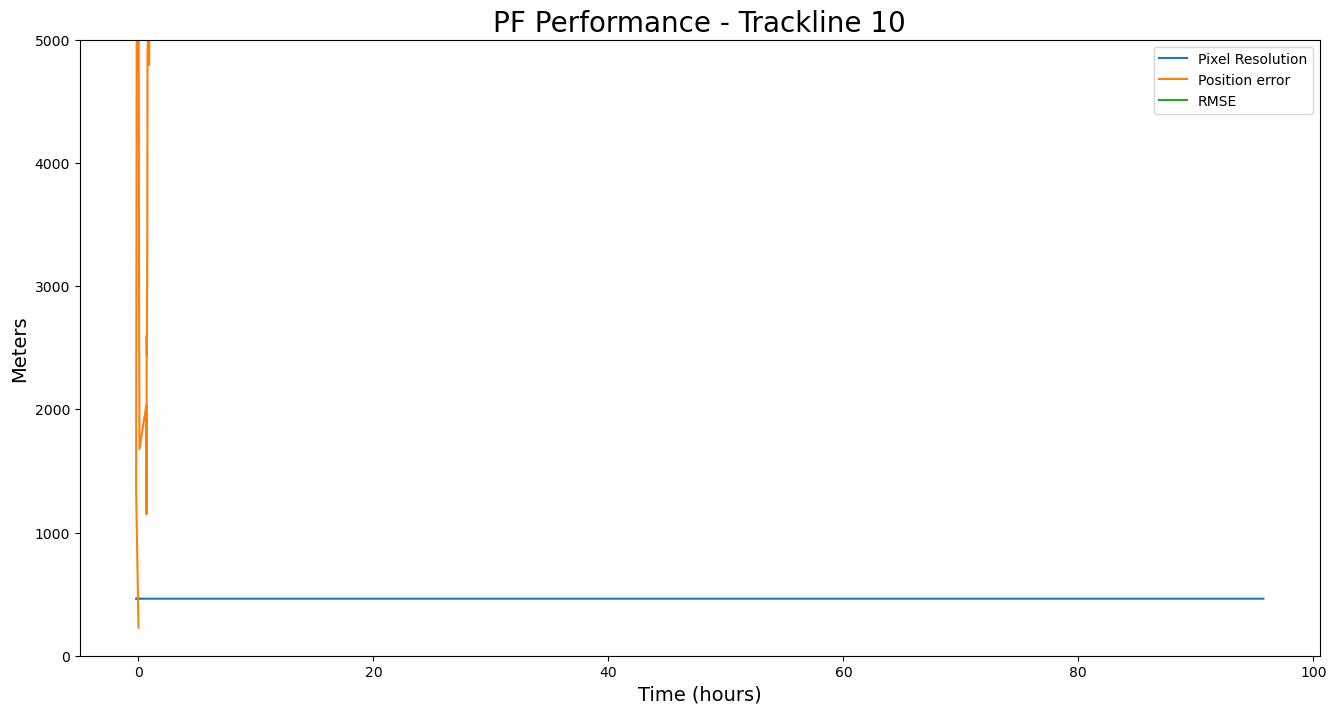

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-47.65320249999999/-40.576547500000004/29.86538/31.139 -Gtrack11.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-47.65320249999999/-40.576547500000004/29.86538/31.139 -Gtrack11.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -47.6532025 to -47.6541666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -40.5765475 to -40.575\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 29.86538 to 29.8625\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 31.139 to 31.1416666667\n\n')


<Figure size 640x480 with 0 Axes>

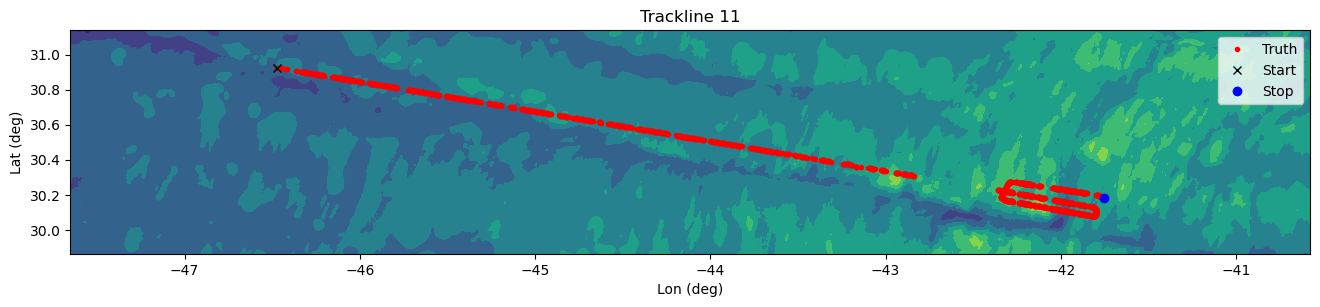

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

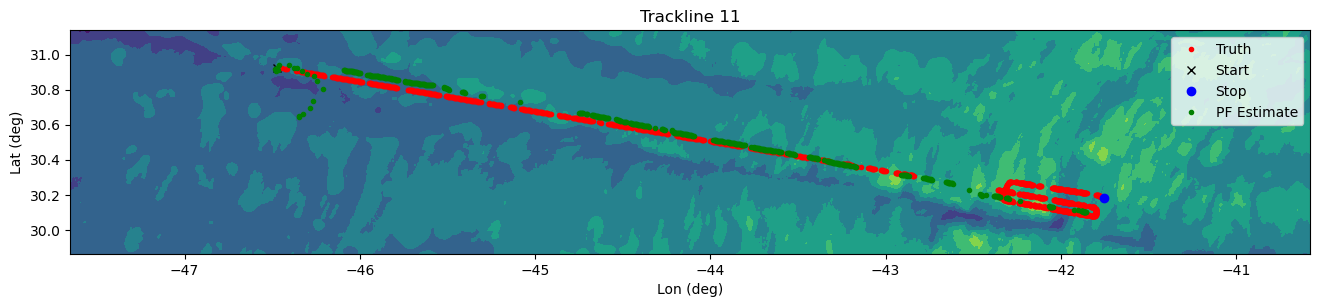

<Figure size 640x480 with 0 Axes>

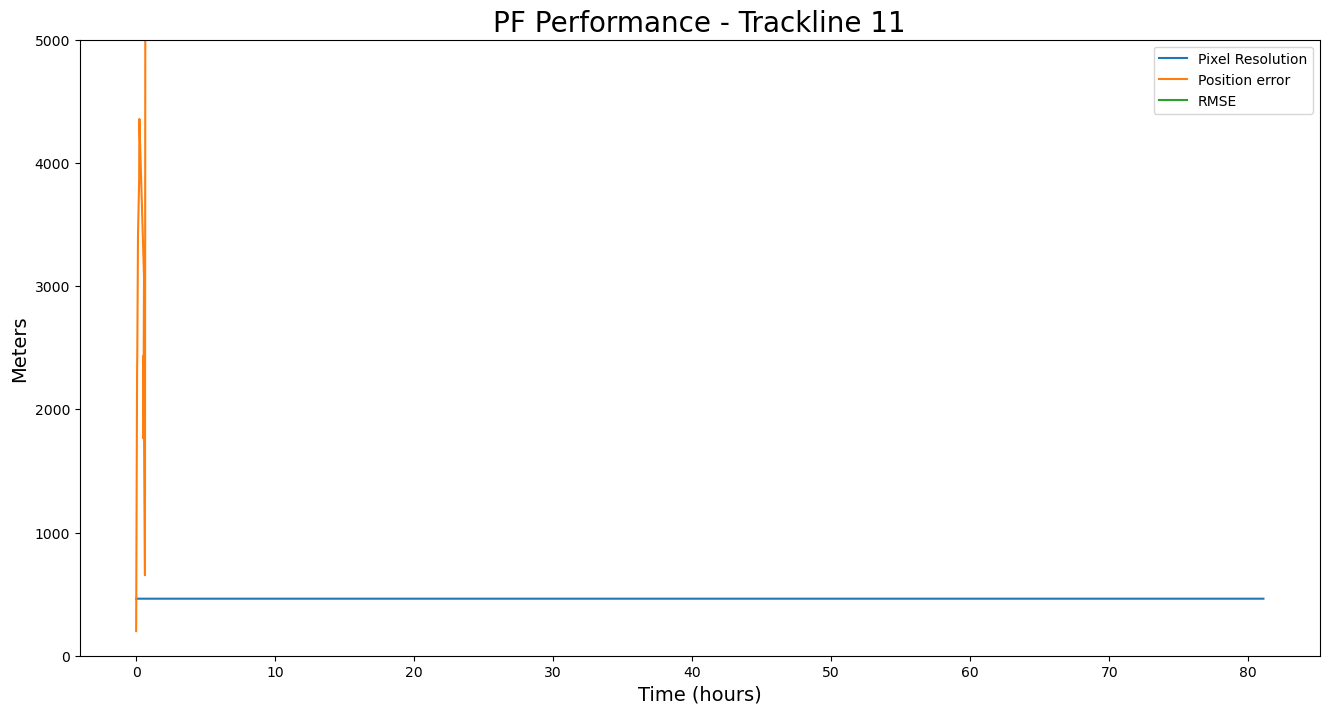

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd-42.35966250000001/-41.7485475/29.9579125/30.3936175 -Gtrack12.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-42.35966250000001/-41.7485475/29.9579125/30.3936175 -Gtrack12.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -42.3596625 to -42.3625\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -41.7485475 to -41.7458333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 29.9579125 to 29.9541666667\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 30.3936175 to 30.3958333333\n\n')


<Figure size 640x480 with 0 Axes>

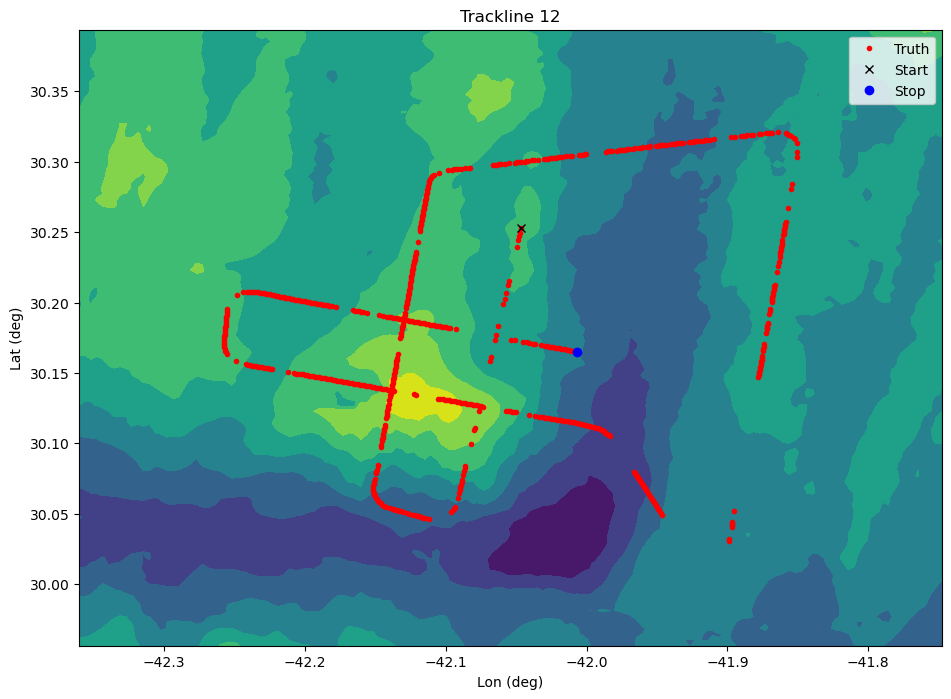

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

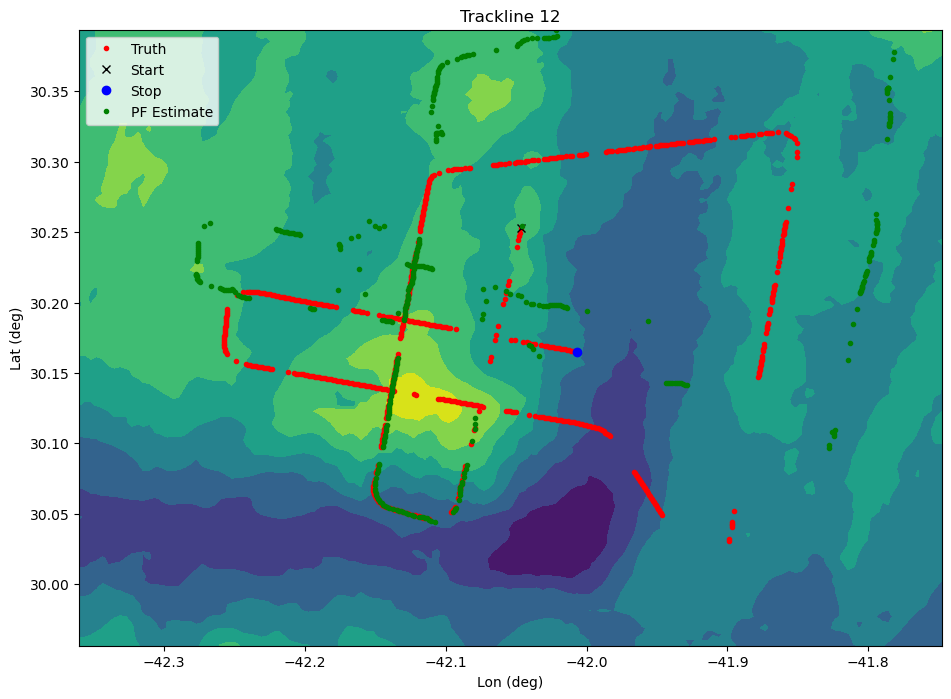

<Figure size 640x480 with 0 Axes>

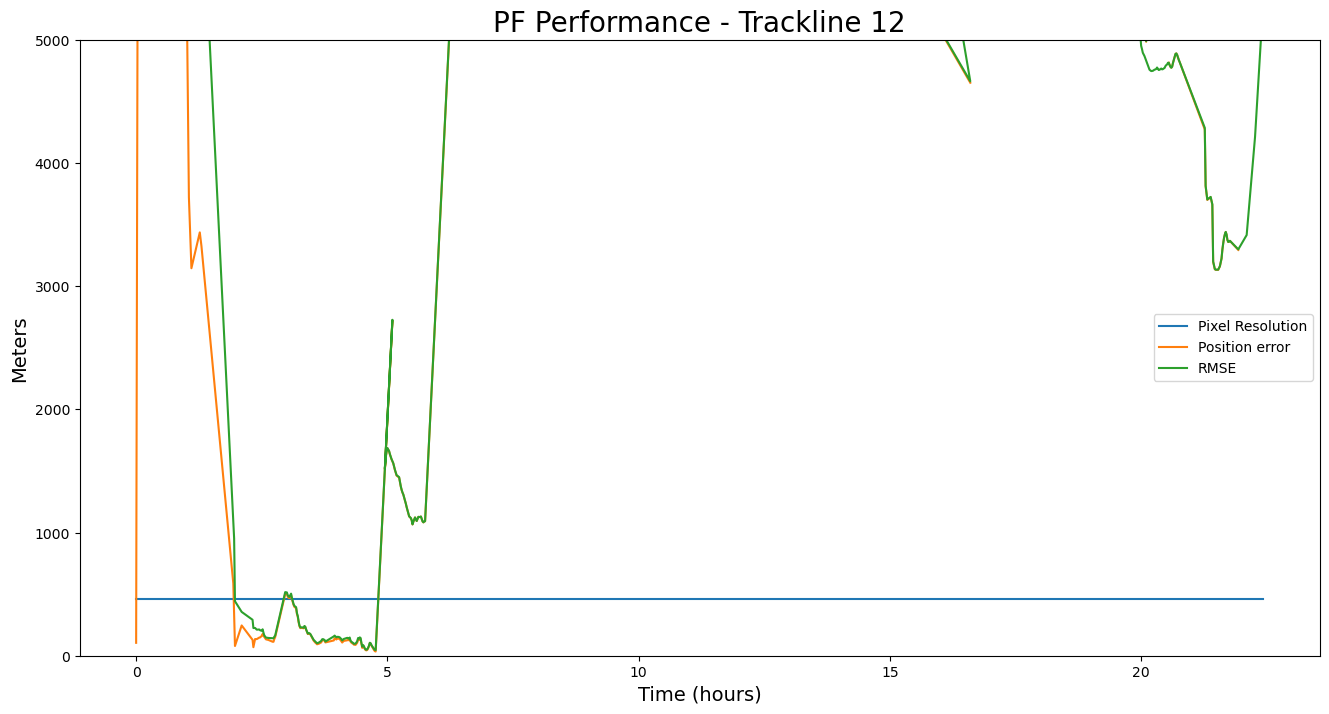

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd68.49788749999999/85.48816250000004/-22.393069999999998/-13.273489999999999 -Gtrack13.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd68.49788749999999/85.48816250000004/-22.393069999999998/-13.273489999999999 -Gtrack13.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 68.4978875 to 68.4958333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 85.4881625 to 85.4916666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -22.39307 to -22.3958333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -13.27349 to -13.2708333333\n\n')


<Figure size 640x480 with 0 Axes>

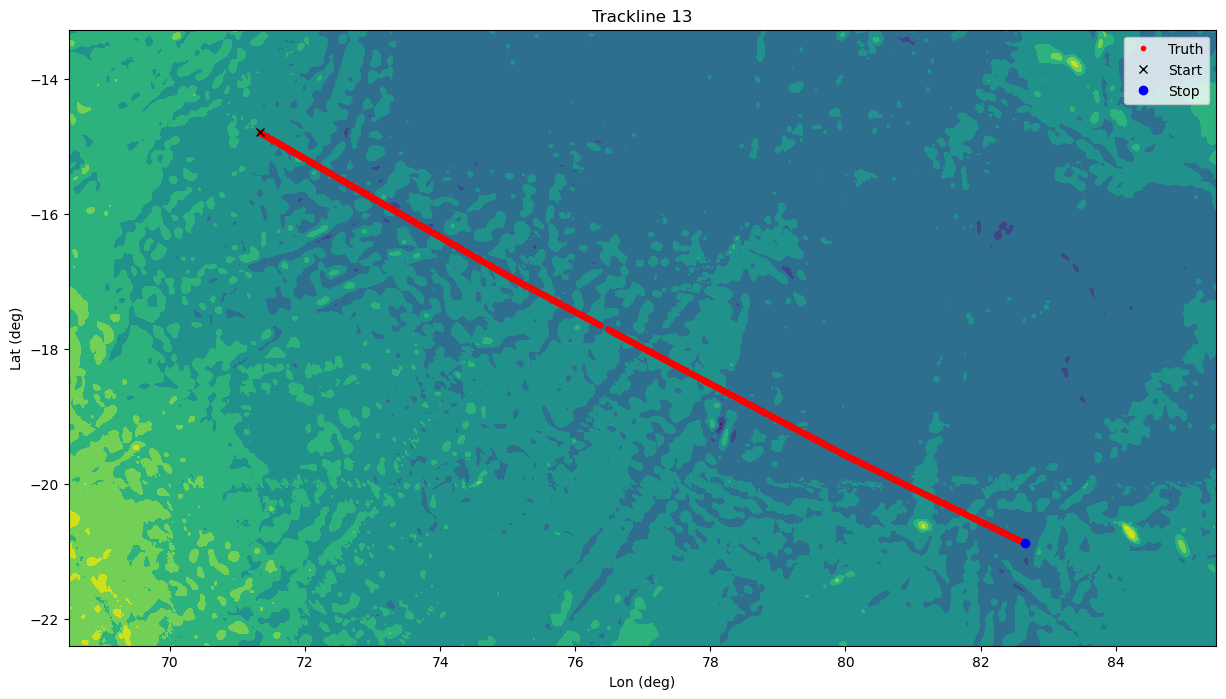

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

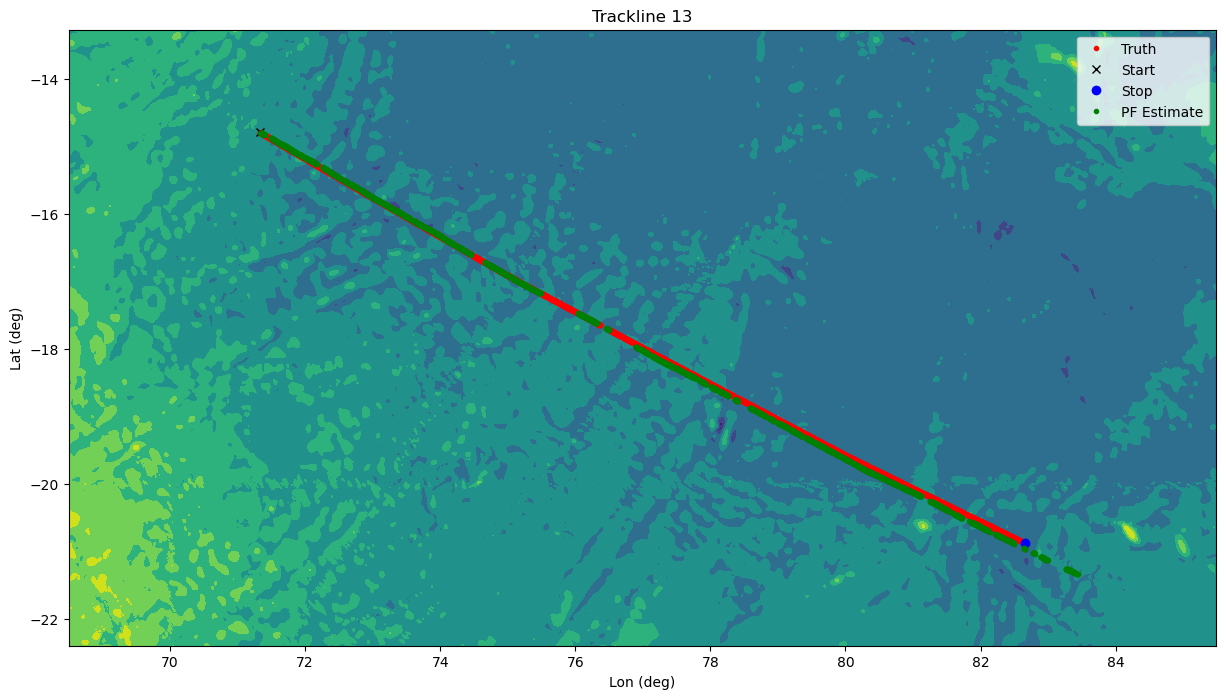

<Figure size 640x480 with 0 Axes>

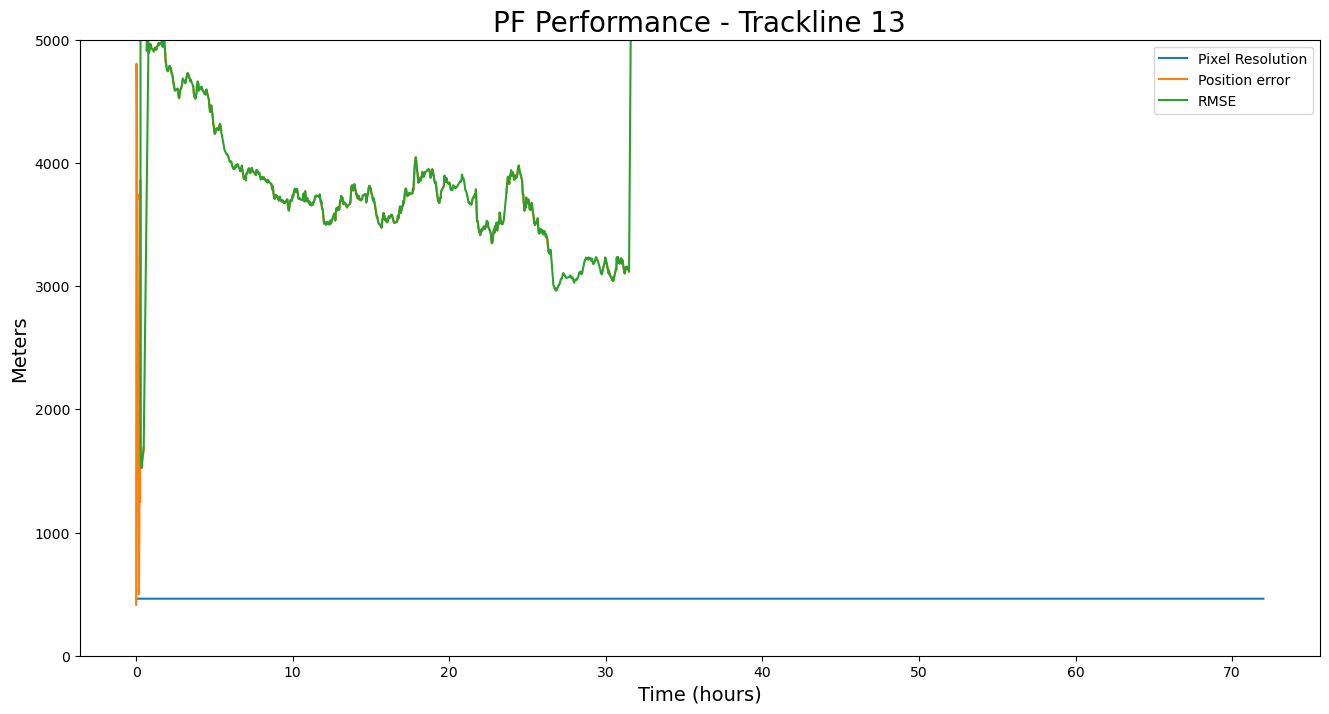

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd98.14033/112.23247000000003/-49.5169525/-35.7126775 -Gtrack14.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd98.14033/112.23247000000003/-49.5169525/-35.7126775 -Gtrack14.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 98.14033 to 98.1375\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 112.23247 to 112.233333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -49.5169525 to -49.5208333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -35.7126775 to -35.7125\n\n')


<Figure size 640x480 with 0 Axes>

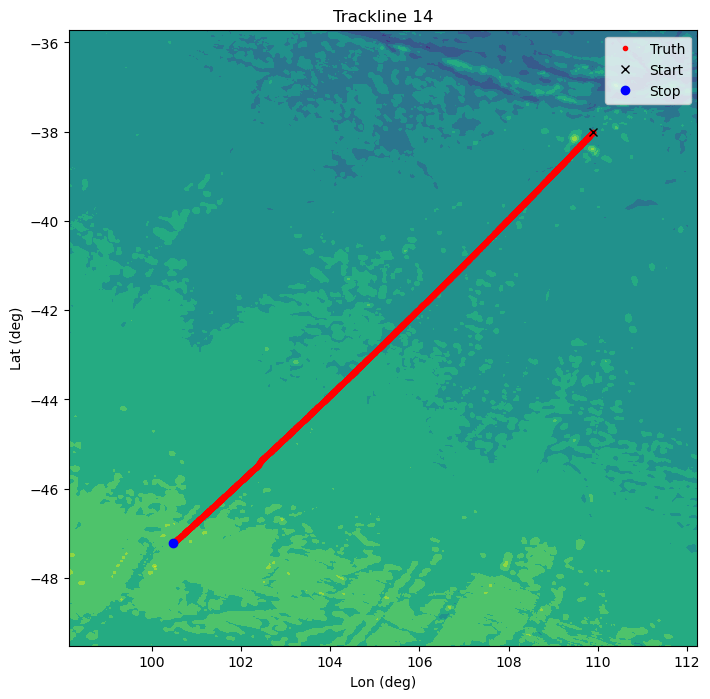

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

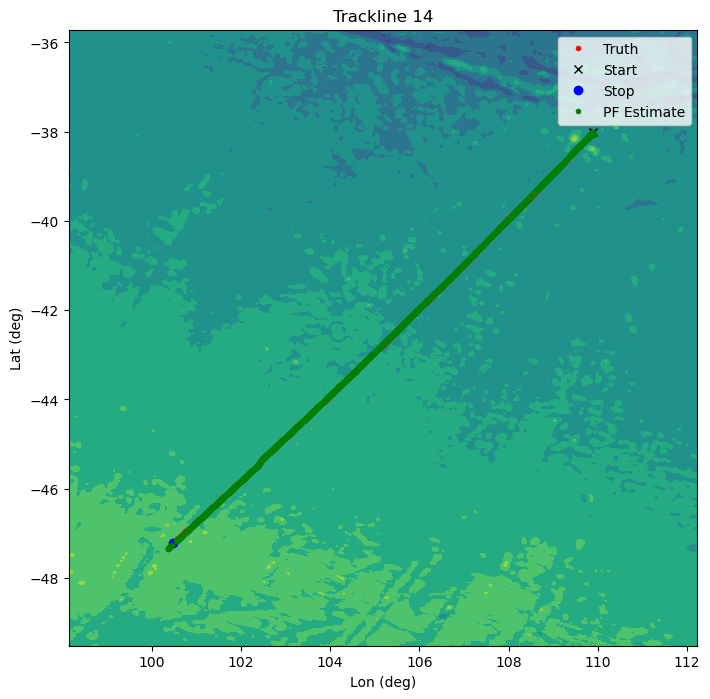

<Figure size 640x480 with 0 Axes>

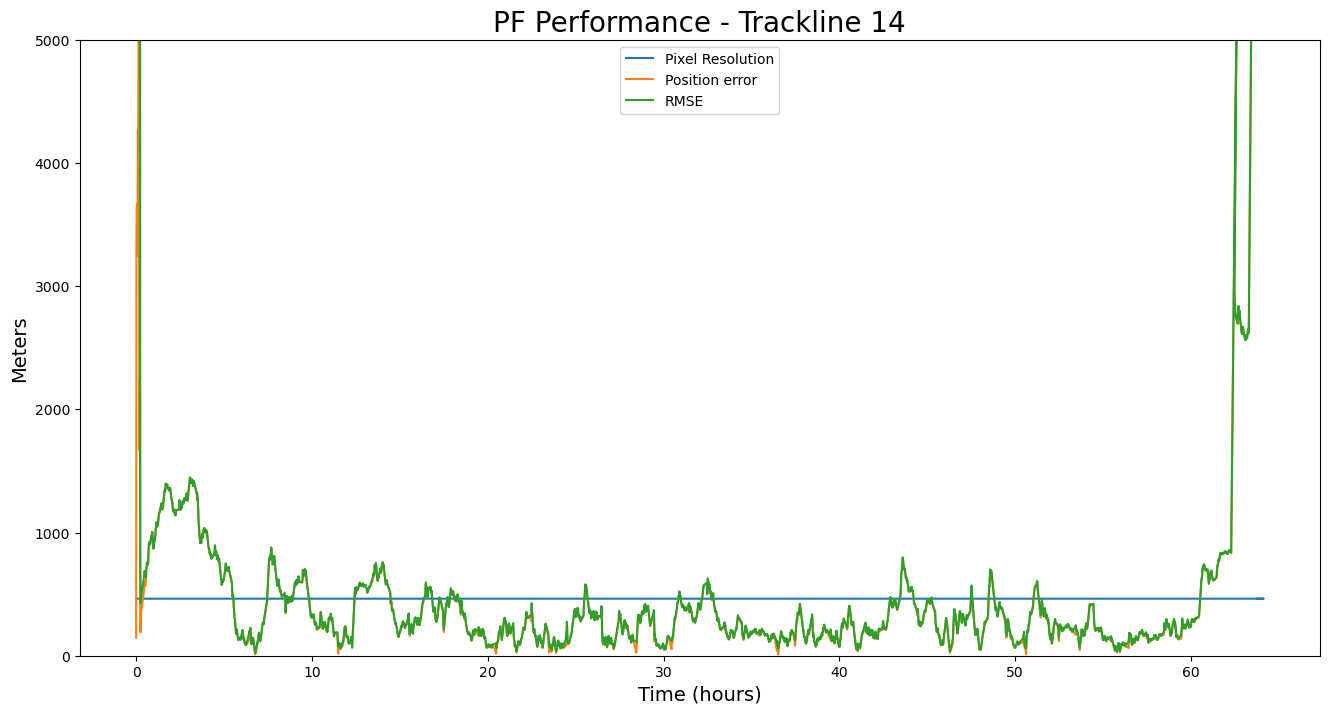

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd99.66274499999997/102.98215500000003/-48.40363/-46.81135 -Gtrack15.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd99.66274499999997/102.98215500000003/-48.40363/-46.81135 -Gtrack15.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 99.662745 to 99.6625\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 102.982155 to 102.983333333\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -48.40363 to -48.4041666667\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -46.81135 to -46.8083333333\n\n')


<Figure size 640x480 with 0 Axes>

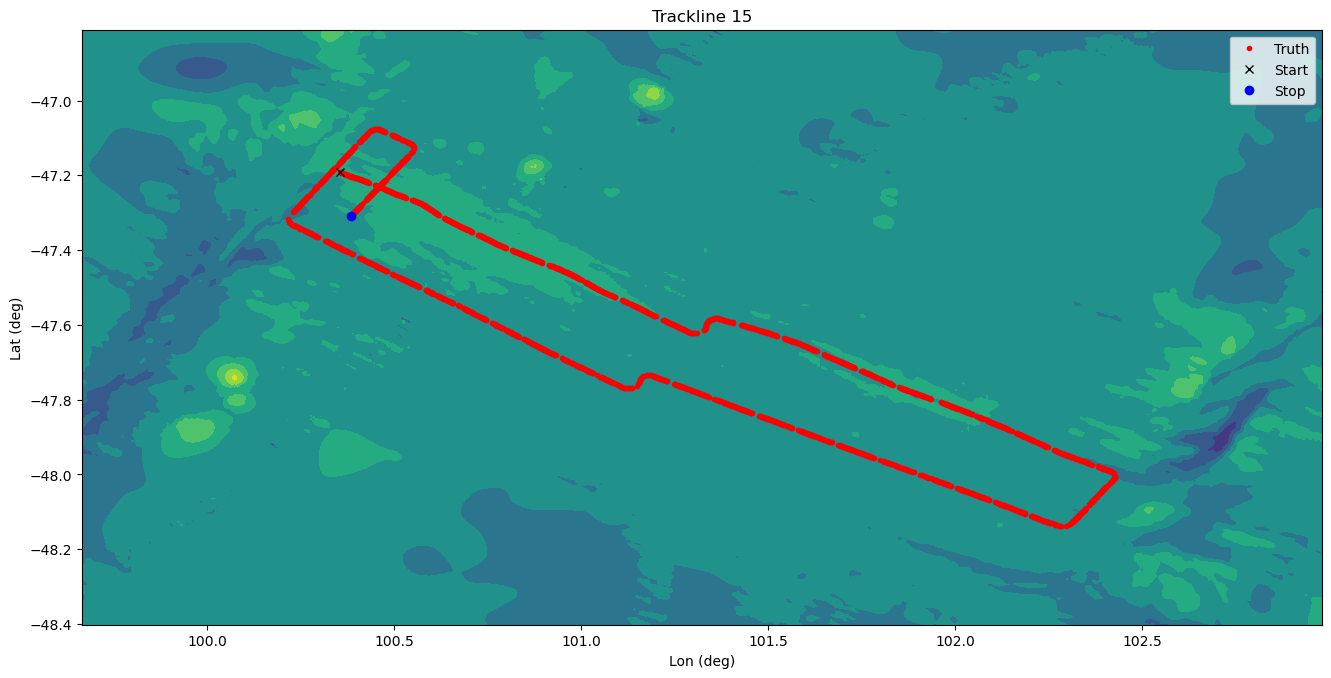

<Figure size 640x480 with 0 Axes>

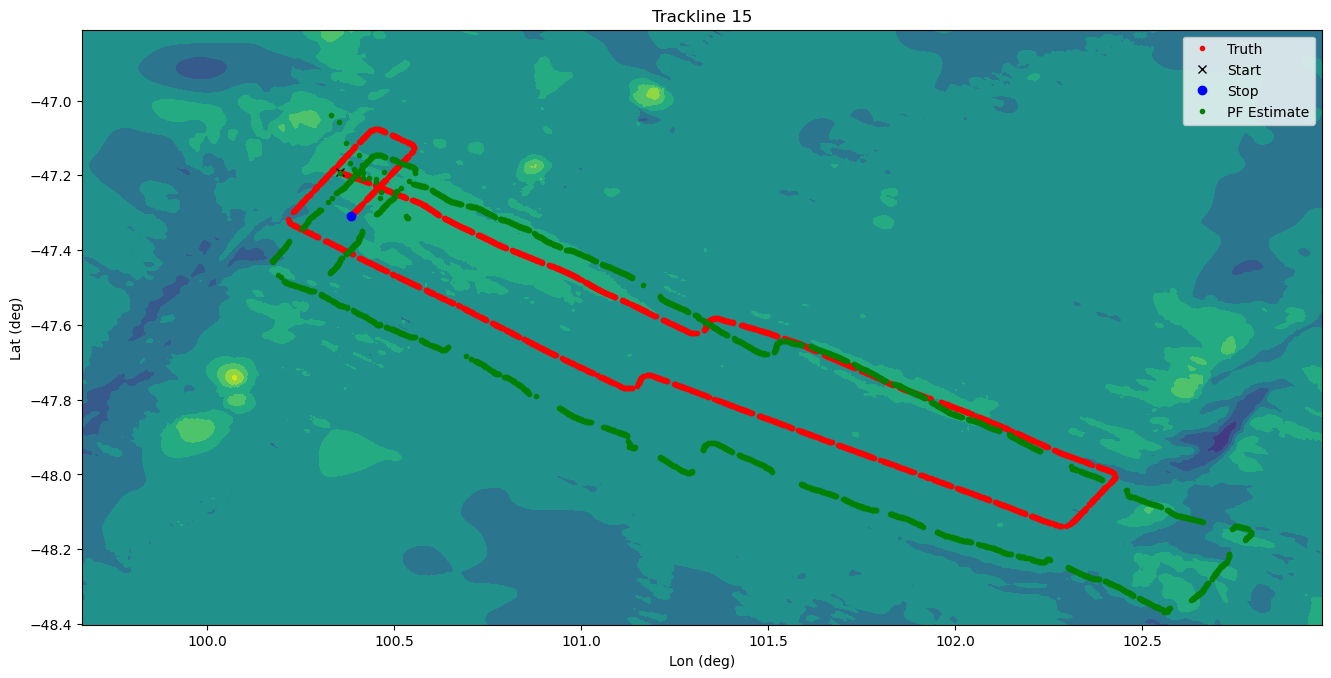

<Figure size 640x480 with 0 Axes>

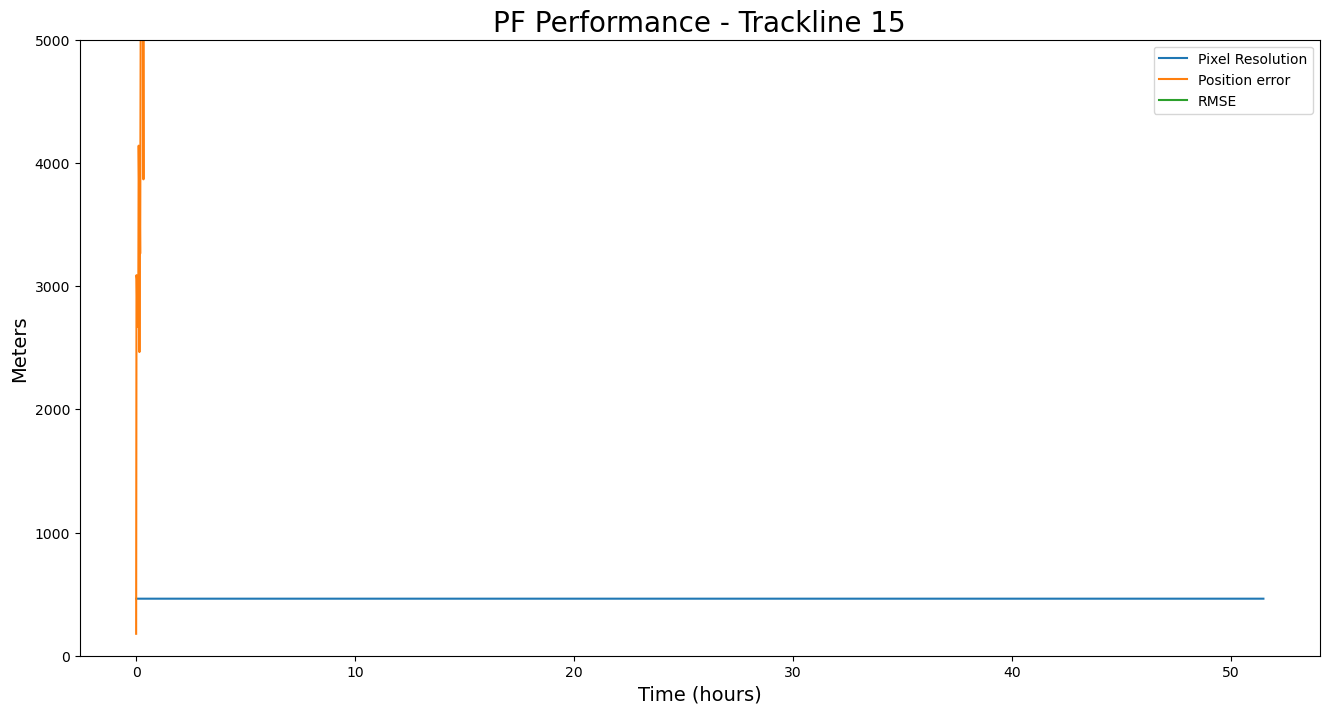

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd101.39120249999996/112.4880675/-50.582915/-47.316485 -Gtrack16.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd101.39120249999996/112.4880675/-50.582915/-47.316485 -Gtrack16.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 101.3912025 to 101.3875\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 112.4880675 to 112.491666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -50.582915 to -50.5833333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -47.316485 to -47.3125\n\n')


<Figure size 640x480 with 0 Axes>

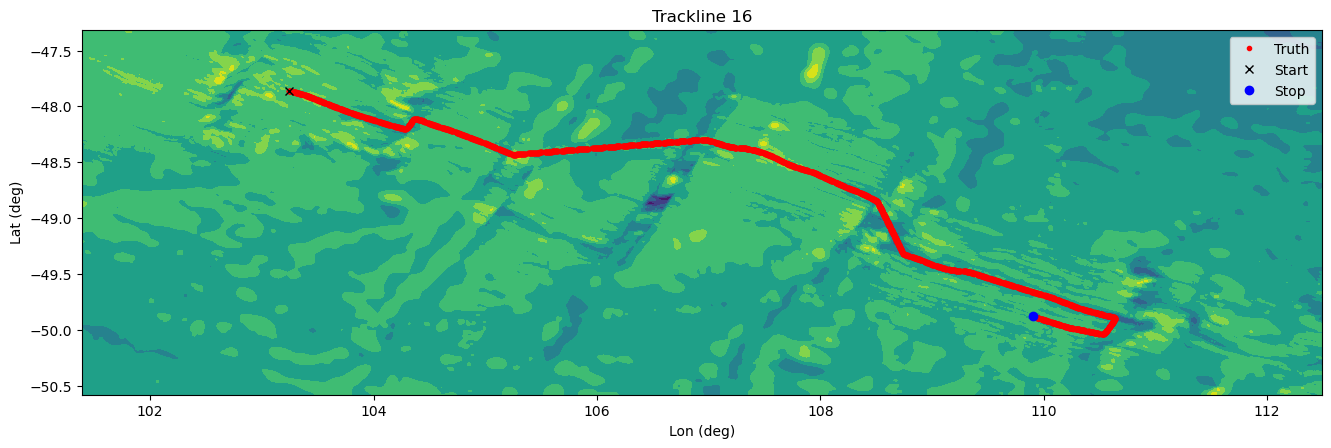

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

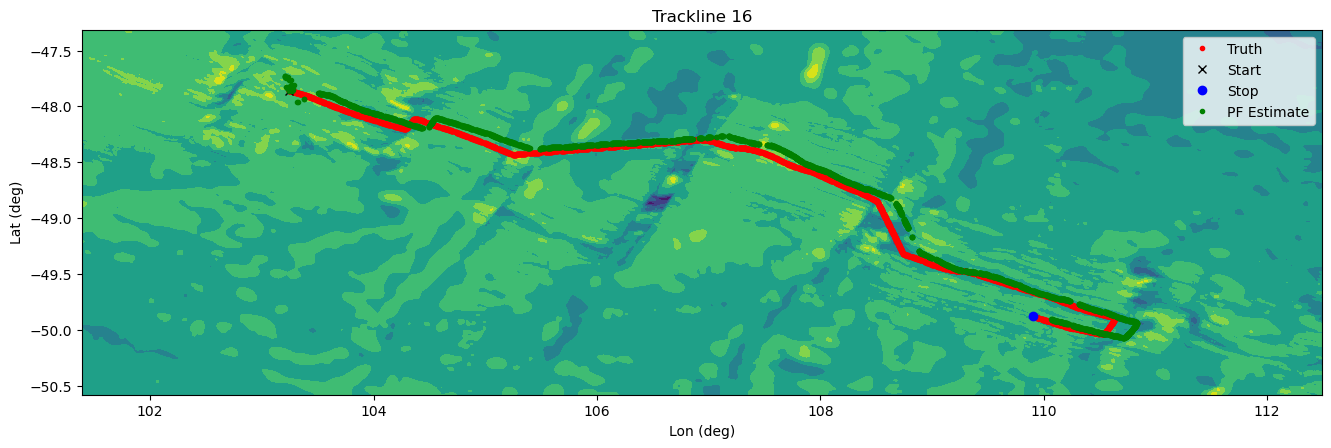

<Figure size 640x480 with 0 Axes>

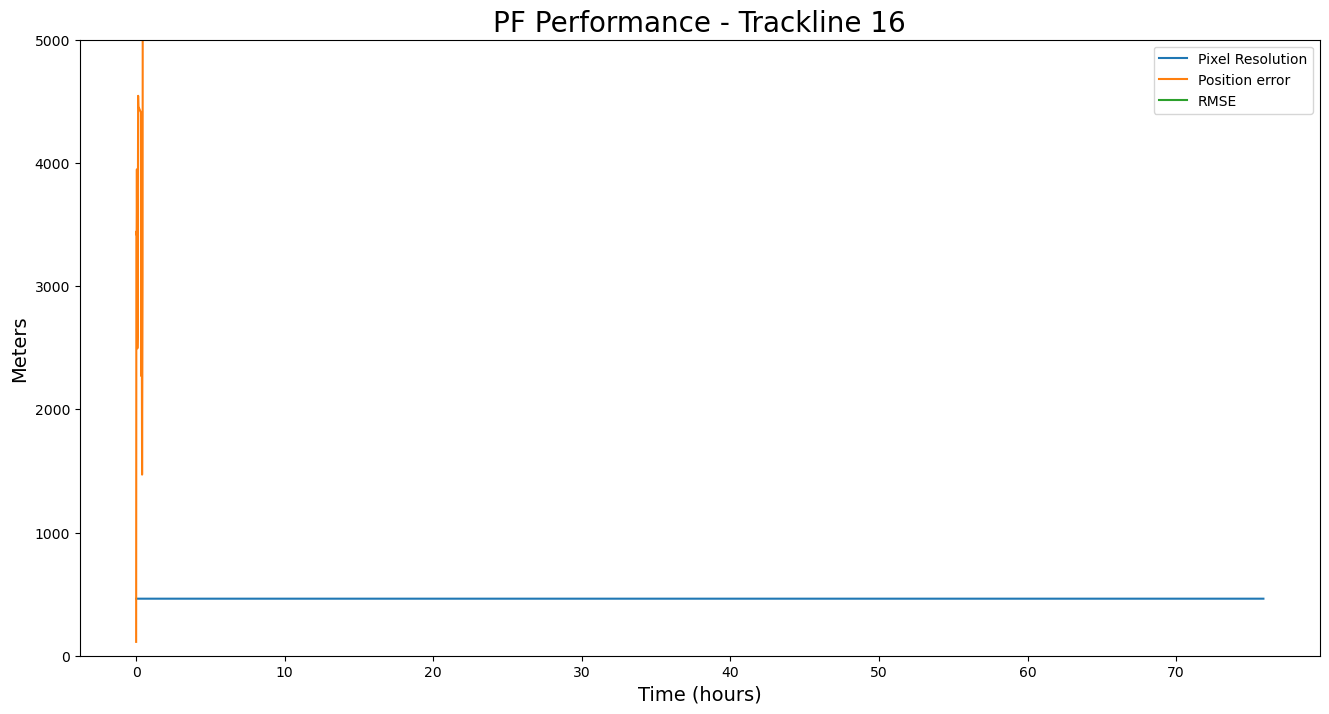

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd109.41493000000003/110.82577000000003/-50.1463075/-49.2073225 -Gtrack17.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd109.41493000000003/110.82577000000003/-50.1463075/-49.2073225 -Gtrack17.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 109.41493 to 109.4125\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 110.82577 to 110.829166667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -50.1463075 to -50.15\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -49.2073225 to -49.2041666667\n\n')


<Figure size 640x480 with 0 Axes>

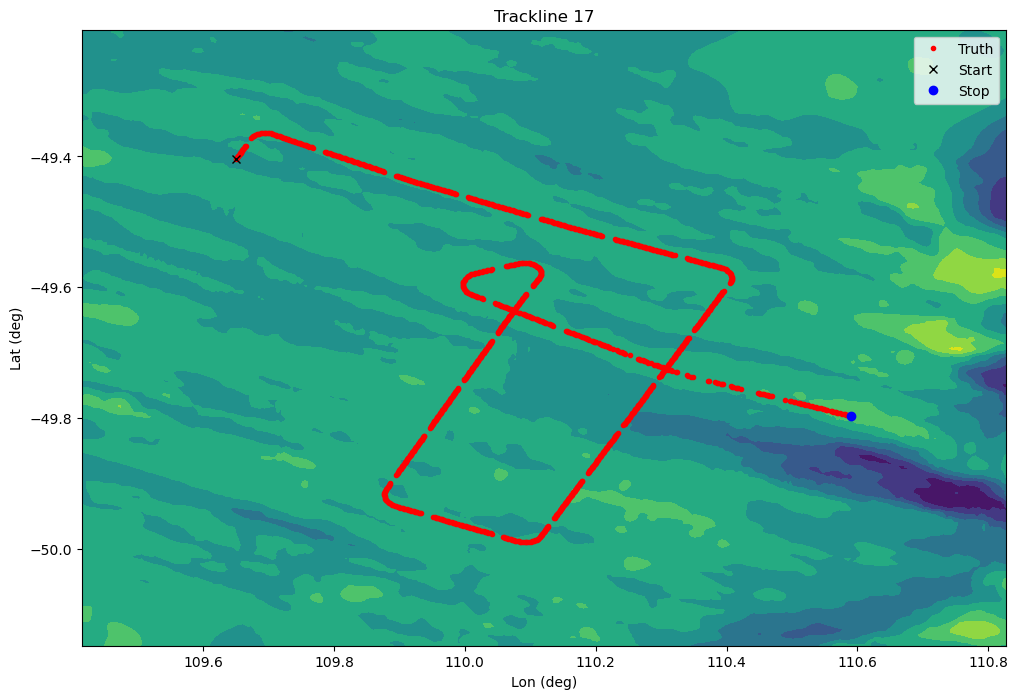

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

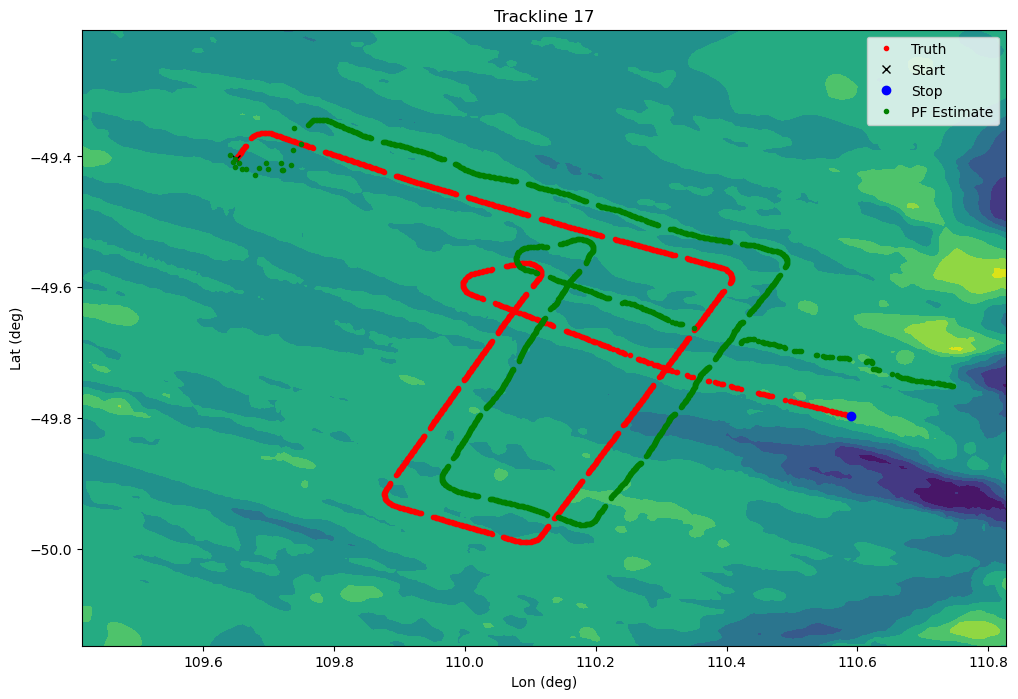

<Figure size 640x480 with 0 Axes>

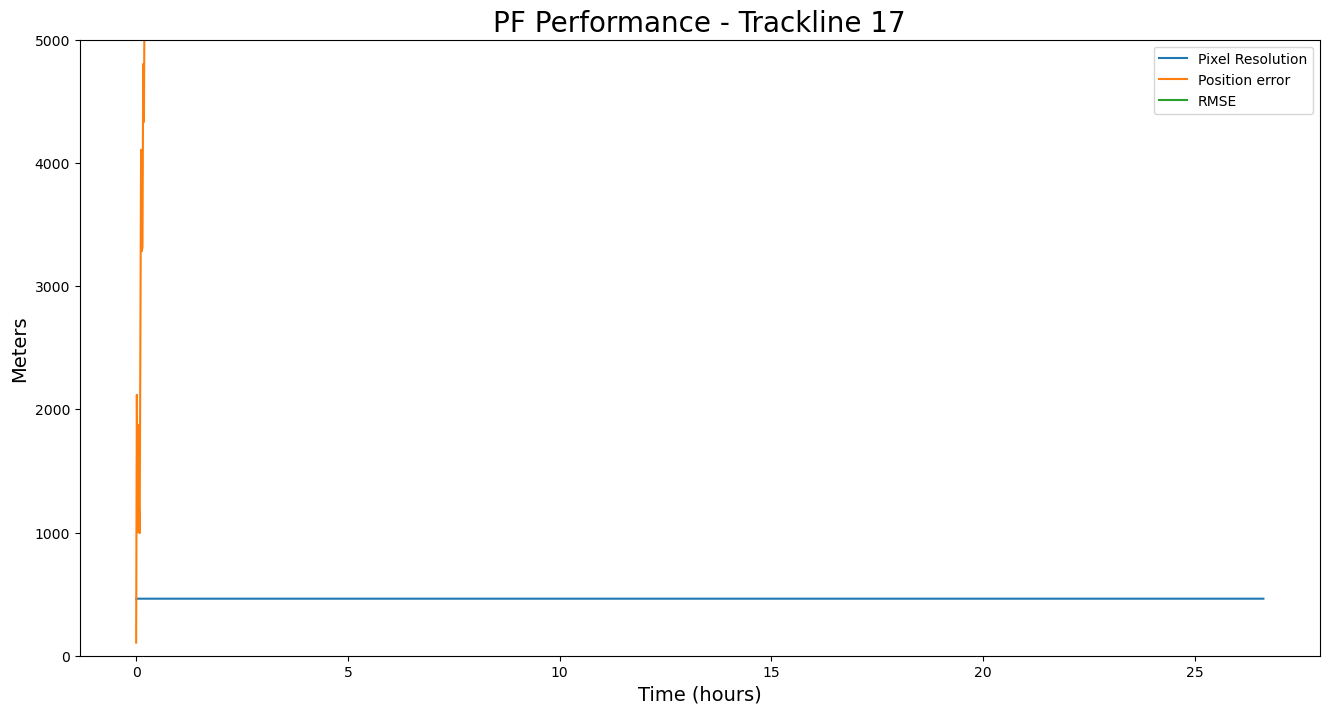

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd114.58496250000002/118.88844749999998/-50.38516750000001/-48.57360249999999 -Gtrack18.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd114.58496250000002/118.88844749999998/-50.38516750000001/-48.57360249999999 -Gtrack18.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 114.5849625 to 114.583333333\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 118.8884475 to 118.891666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -50.3851675 to -50.3875\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -48.5736025 to -48.5708333333\n\n')


<Figure size 640x480 with 0 Axes>

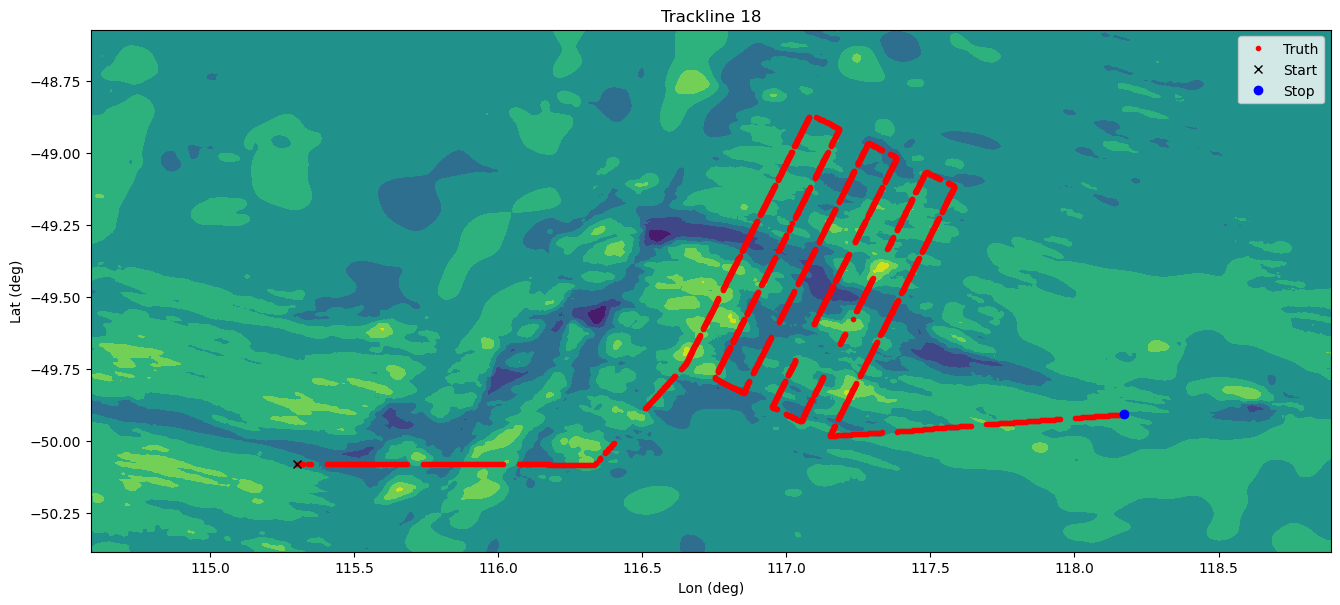

c:\Users\james\geophysical_nav\research\particle_filter.py:82: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
c:\Users\james\anaconda3\envs\geophysical_nav\Lib\site-packages\filterpy\monte_carlo\resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)


<Figure size 640x480 with 0 Axes>

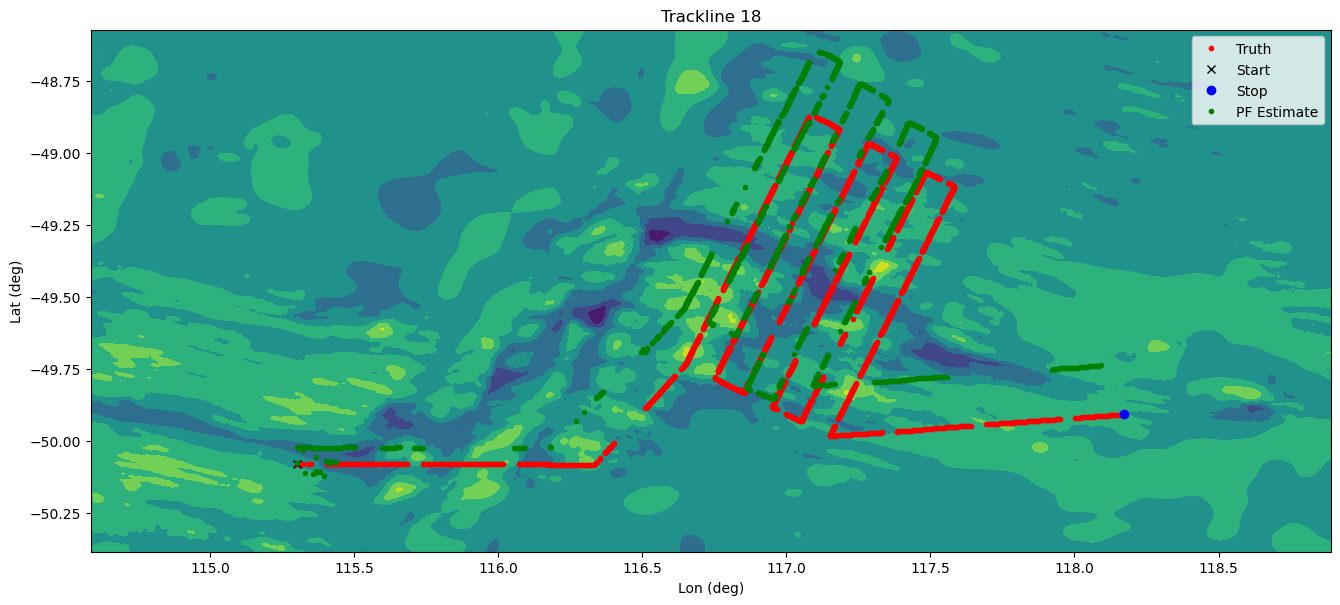

<Figure size 640x480 with 0 Axes>

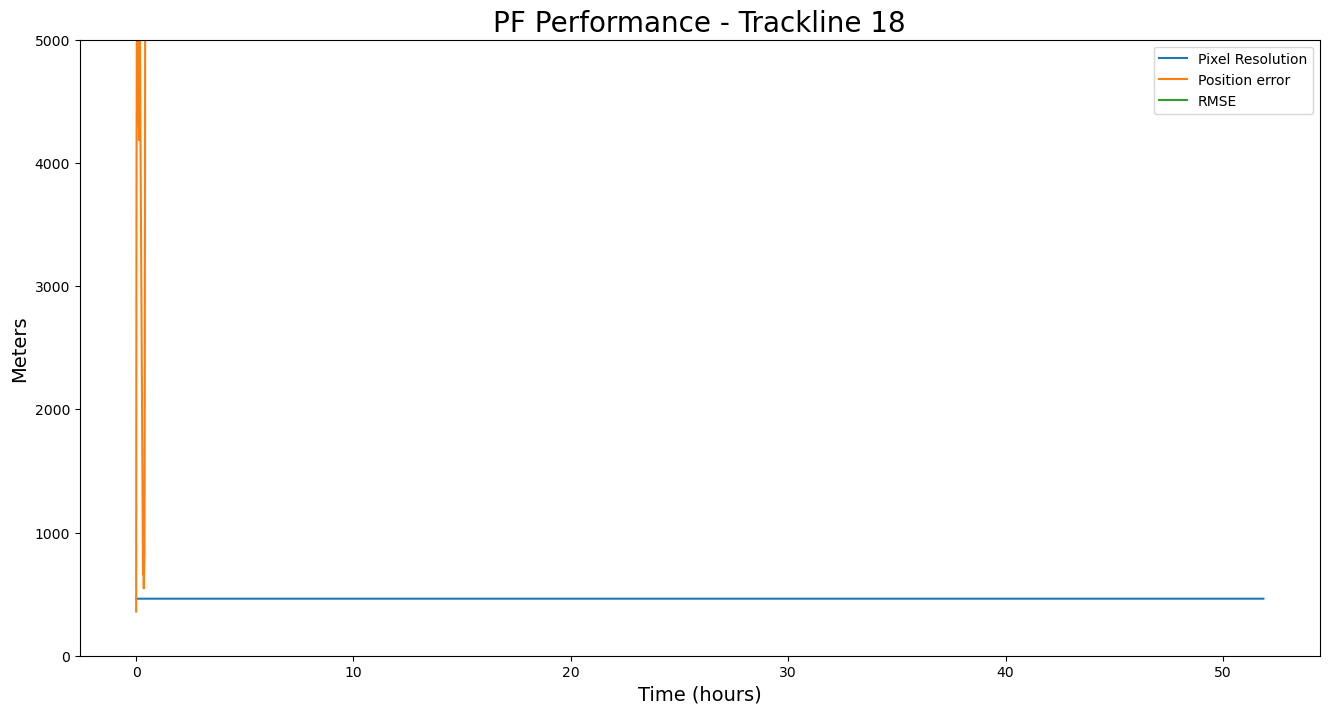

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


gmt grdcut @earth_relief_15s_p -Rd119.86845249999999/140.9111575/-50.068255/-46.093165 -Gtrack19.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd119.86845249999999/140.9111575/-50.068255/-46.093165 -Gtrack19.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from 119.8684525 to 119.866666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from 140.9111575 to 140.9125\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from -50.068255 to -50.0708333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from -46.093165 to -46.0916666667\n\n')


<Figure size 640x480 with 0 Axes>

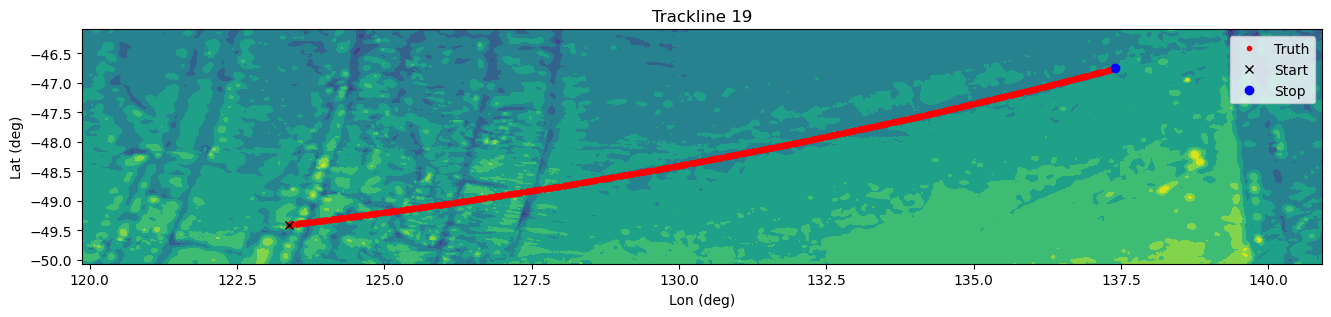

<Figure size 640x480 with 0 Axes>

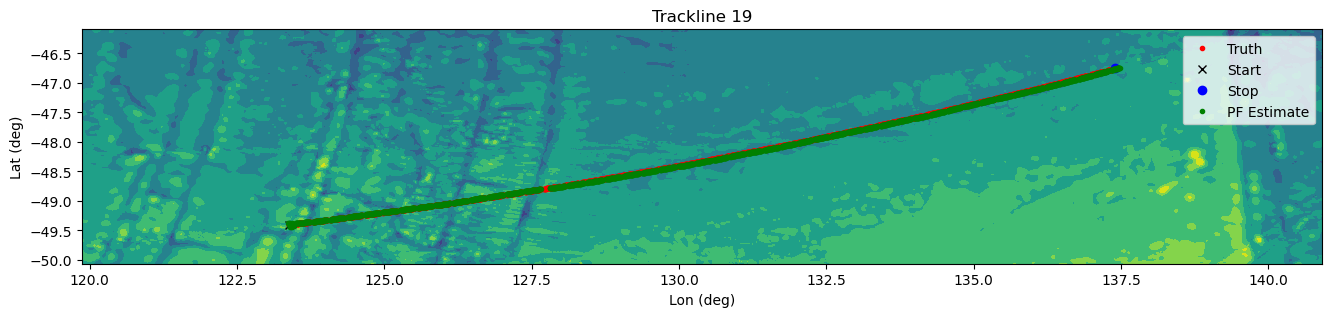

<Figure size 640x480 with 0 Axes>

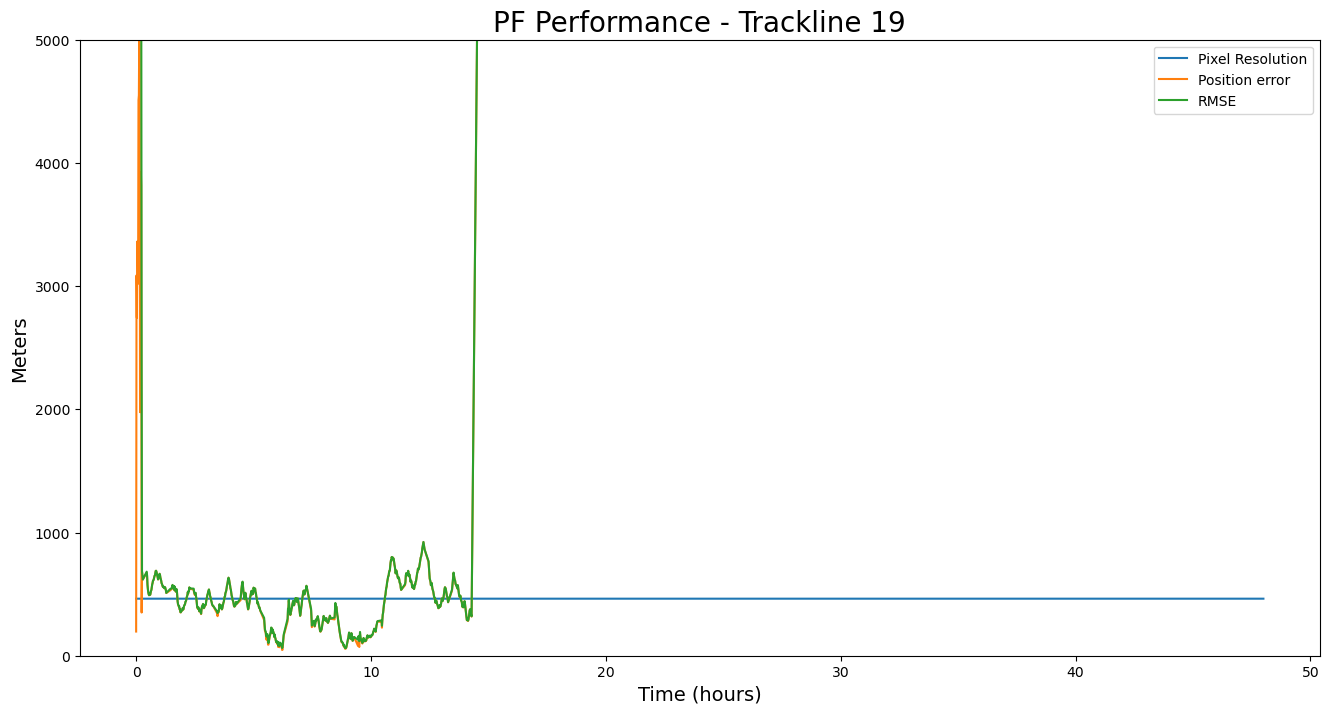

<Figure size 640x480 with 0 Axes>

In [3]:
# Load the trajectory file
for num in range(20):
    name = f'marine_trackline_{num}'
    data = load_trackline_data(f'./data/processed/{name}.csv')

    # Create the map
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    geo_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'relief', '15s', f'track{num}')
    
    # Plot the map and the trajectory
    fig, ax = plt.subplots(1,1, figsize=(16,8))
    ax.contourf(geo_map.lon, geo_map.lat, geo_map.data)
    ax.plot(data.LON, data.LAT, '.r', label='Truth')
    ax.plot(data.LON[0], data.LAT[0], 'xk', label='Start')
    ax.plot(data.LON[-1], data.LAT[-1], 'bo', label='Stop')
    ax.set(xlim = [min_lon, max_lon])
    ax.set(ylim = [min_lat, max_lat])
    ax.axis('image')
    ax.legend()
    ax.set(xlabel ='Lon (deg)')
    ax.set(ylabel ='Lat (deg)')
    ax.set(title=f'Trackline {num}')
    plt.show()
    plt.savefig(f'{name}.png')

    # Run the particle filter
    N = 10000
    # Intial parameters
    mu = [data.LAT[0], data.LON[0], 0, 0, 0, 0]
    cov = np.diag([1/60, 1/60, 0, 0.1, 0.1, 0])
    # Run PF
    estimate, error, rms_error = run_particle_filter(mu, cov, N, data, geo_map, measurement_sigma=bathy_sigma)

    # Plot the particle filter estimate
    fig, ax = plt.subplots(1,1, figsize=(16,8))
    ax.contourf(geo_map.lon, geo_map.lat, geo_map.data)
    ax.plot(data.LON, data.LAT, '.r', label='Truth')
    ax.plot(data.LON[0], data.LAT[0], 'xk', label='Start')
    ax.plot(data.LON[-1], data.LAT[-1], 'bo', label='Stop')
    ax.set(xlim = [min_lon, max_lon])
    ax.set(ylim = [min_lat, max_lat])
    ax.set(xlabel ='Lon (deg)')
    ax.set(ylabel ='Lat (deg)')
    ax.set(title=f'Trackline {num}')
    ax.plot(estimate[:, 1], estimate[:, 0], 'g.', label='PF Estimate')
    ax.axis('image')
    ax.legend()
    plt.show()
    plt.savefig(f'{name}_Results.png')

    # Plot the particle filter error characteristics
    res = haversine((0,0), (geo_map.lat[1] - geo_map.lat[0], 0), Unit.METERS)
    fig, ax = plt.subplots(1,1,figsize=(16,8))
    ax.plot(data['TIME'] / timedelta(hours=1), np.ones_like(data['TIME'])*res, label='Pixel Resolution')
    ax.plot(data['TIME'] / timedelta(hours=1), error, label='Position error')
    ax.plot(data['TIME'] / timedelta(hours=1), rms_error, label='RMSE')
    #ax.plot(data['TIME'] / timedelta(hours=1), weighted_rmse, label='Weighted RMSE')
    ax.set_xlabel('Time (hours)', size=14)
    ax.set_ylabel('Meters', size=14)
    ax.set_title(f'PF Performance - Trackline {num}', size=20)
    ax.set_ylim([0, 5000])
    ax.legend()
    plt.show()
    plt.savefig(f'{name}_Error.png')

    # Save particle filter error characteristics.
    results = {'estimate':estimate, 'error':error, 'rmse':rms_error}
    savemat(f'{name}_errors.mat', results)